In [1]:
import glob
import pandas as pd
import numpy as np
import os
import glob

#with the provided file path, create a list of all the file paths of the files in the directory that end with .npy
file_paths = glob.glob('/Users/cresp1el/Documents/lmc_project_analysis_dir/analysis_directory/*.npy')

file_paths  #print the list of file paths

# Define the updated parse_filename function
def parse_filename(file_path):
    """
    This function parses the filename of a .npy file to extract the group ID, cell ID, 
    CTZ condition, and stimulation level. The filename is assumed to be in one of the following formats:
    'Lmc_opsin_lmc_ch_2_3093_rec1_cid<cell_id>_<ctz_condition>_SpikeTrains_for_PSTHs_<stimulation_level>.npy'
    'Lmc_noopsin_lmc_noch_1_3096_rec1_cid<cell_id>_<ctz_condition>_SpikeTrains_for_PSTHs_<stimulation_level>.npy'
    """
    #first only keep the file name, not the path
    file_path = file_path.split("/")[-1] # Split the path and keep the last part
    
    # Split the filename into parts
    parts = file_path.split("_")

    # Extract the group ID
    group_id = parts[1]  # The group ID is the 2nd part

    # Extract the cell ID, CTZ condition, and stimulation level
    cell_id_part = [part for part in parts if 'cid' in part][0]  # Find the part with 'cid'
    cell_id = int(cell_id_part.replace('cid', ''))  # Remove 'cid' to get the cell ID
    
    ctz_condition = parts[8]  # The CTZ condition is the 9th part
    stimulation_level = parts[12].split(".")[0]  # The stimulation level is before '.npy' in the 13th part

    # Extract the mouse ID
    mouse_id = parts[5]  # The mouse ID is the 5th part

    return group_id, cell_id, ctz_condition, stimulation_level, mouse_id


# Parse the file names and create a new DataFrame
data = []
for file_path in file_paths:
    group_id, cell_id, ctz_condition, stimulation_level, mouse_id = parse_filename(file_path)
    data.append([group_id, cell_id, ctz_condition, stimulation_level, mouse_id, file_path])

# Create the DataFrame
df = pd.DataFrame(data, columns=["group_id", "cell_id", "ctz_condition", "stimulation_level", "mouse_id", "filename"])

df.head()


group_id  cell_id ctz_condition stimulation_level mouse_id  \
0  noopsin       22           pre               low     3096   
1    opsin      156           pre              high     3094   
2    opsin      113           pre              zero     3094   
3    opsin       39           pre               mid     3093   
4  noopsin      219           pre              high     3096   

                                            filename  
0  /Users/cresp1el/Documents/lmc_project_analysis...  
1  /Users/cresp1el/Documents/lmc_project_analysis...  
2  /Users/cresp1el/Documents/lmc_project_analysis...  
3  /Users/cresp1el/Documents/lmc_project_analysis...  
4  /Users/cresp1el/Documents/lmc_project_analysis...

In [2]:
def combine_matrices(df):
    # Define an ordering for the stimulation levels
    stimulation_order = {'low': 0, 'mid': 1, 'high': 2}

    # Define the directory to save the combined matrices
    save_directory = "/Users/cresp1el/Documents/lmc_project_analysis_dir/analysis_directory/combined_matrices_lowmidhigh"

    # Ensure the directory exists
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    # Iterate over both CTZ conditions
    for ctz_condition in ['pre', 'post']:
        # Filter the DataFrame for the current CTZ condition and exclude zero intensity
        filtered_df = df[(df['ctz_condition'] == ctz_condition) & (df['stimulation_level'] != 'zero')]

        # Group the filtered DataFrame by unique cell type (group_id), mouse ID, and cell ID
        for (group, mouse_id, cell_id), group_data in filtered_df.groupby(['group_id', 'mouse_id', 'cell_id']):
            # Sort the group data by stimulation level (low, mid, high)
            group_data = group_data.replace({'stimulation_level': stimulation_order}).sort_values('stimulation_level')

            # Initialize a list to store the matrices for low, mid, and high intensities
            matrices = []

            # Initialize a variable to store the sum of rows for low, mid, and high intensities
            total_rows = 0
            
            # Iterate through the sorted rows and load the .npy files
            for _, row in group_data.iterrows():
                file_path = row['filename']
                matrix = np.load(file_path) # Load the .npy file
                matrices.append(matrix)
                total_rows += matrix.shape[0] # Add the number of rows to the total
            
            # Combine the matrices
            combined_matrix = np.concatenate(matrices, axis=0)

            # Verify that the total number of rows matches
            if combined_matrix.shape[0] != total_rows:
                print(f"Error in matrix size for {group}, mouse {mouse_id}, cell {cell_id}, {ctz_condition}.")
                continue

            # Print the final size of the combined matrix
            print(f"Final size for {group}, mouse {mouse_id}, cell {cell_id}, {ctz_condition}: {combined_matrix.shape}")

            # Construct the file name
            file_name = f"{group}_{mouse_id}_{cell_id}_{ctz_condition}_combinedmatrix.npy"
            file_path = os.path.join(save_directory, file_name)
            
            # Save the combined matrix as a .npy file
            np.save(file_path, combined_matrix)

    print("Combined matrices saved successfully.")


combine_matrices(df)

Final size for noopsin, mouse 3096, cell 21, pre: (386, 1500)
Final size for noopsin, mouse 3096, cell 22, pre: (386, 1500)
Final size for noopsin, mouse 3096, cell 24, pre: (369, 1500)
Final size for noopsin, mouse 3096, cell 159, pre: (369, 1500)
Final size for noopsin, mouse 3096, cell 169, pre: (369, 1500)
Final size for noopsin, mouse 3096, cell 211, pre: (386, 1500)
Final size for noopsin, mouse 3096, cell 219, pre: (386, 1500)
Final size for noopsin, mouse 3096, cell 244, pre: (369, 1500)
Final size for noopsin, mouse 3096, cell 251, pre: (369, 1500)
Final size for opsin, mouse 3093, cell 39, pre: (383, 1500)
Final size for opsin, mouse 3093, cell 81, pre: (383, 1500)
Final size for opsin, mouse 3093, cell 93, pre: (383, 1500)
Final size for opsin, mouse 3093, cell 102, pre: (383, 1500)
Final size for opsin, mouse 3094, cell 52, pre: (379, 1500)
Final size for opsin, mouse 3094, cell 79, pre: (367, 1500)
Final size for opsin, mouse 3094, cell 82, pre: (367, 1500)
Final size for 

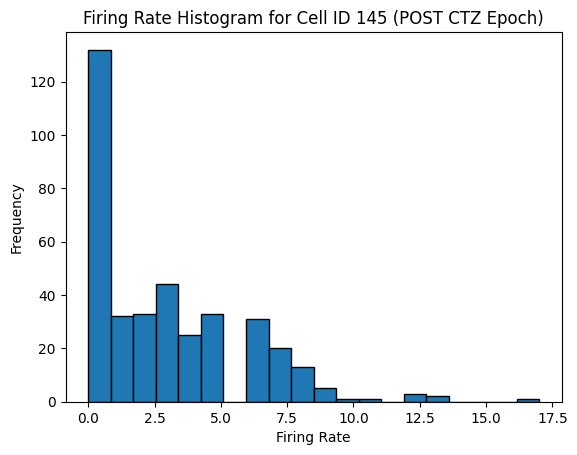

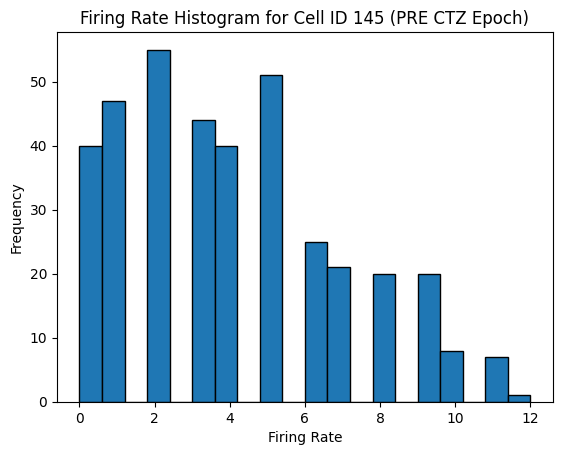

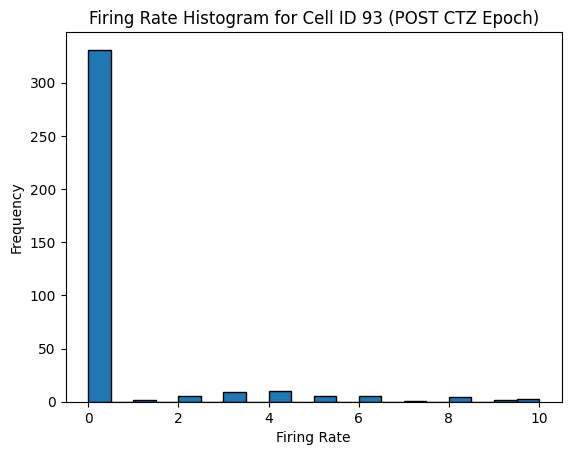

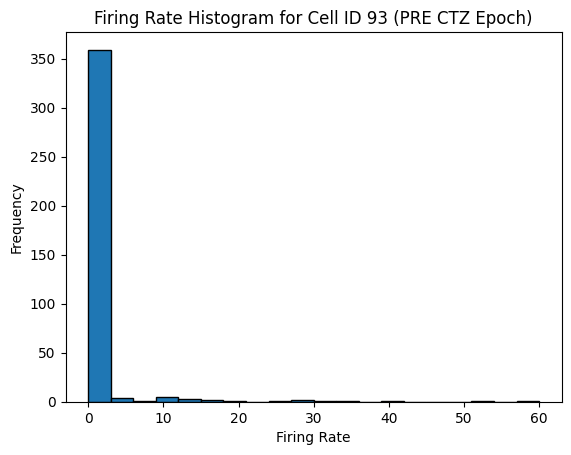

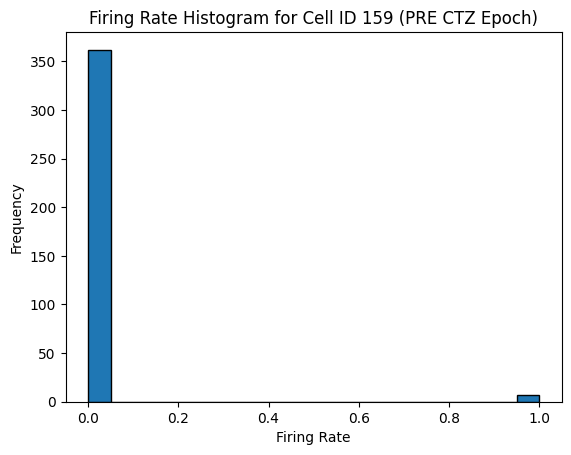

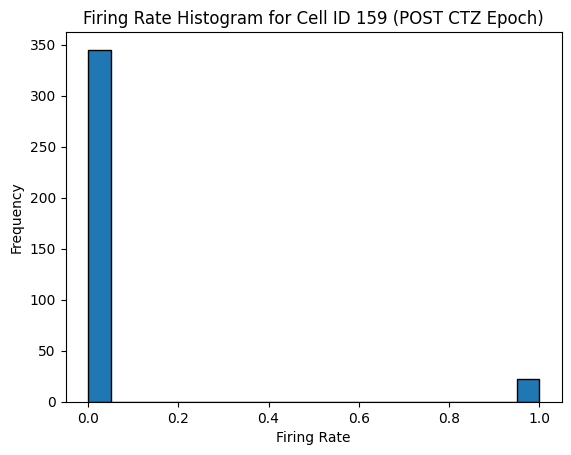

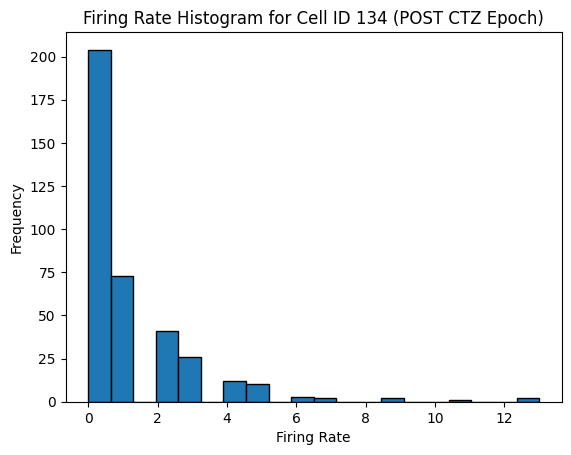

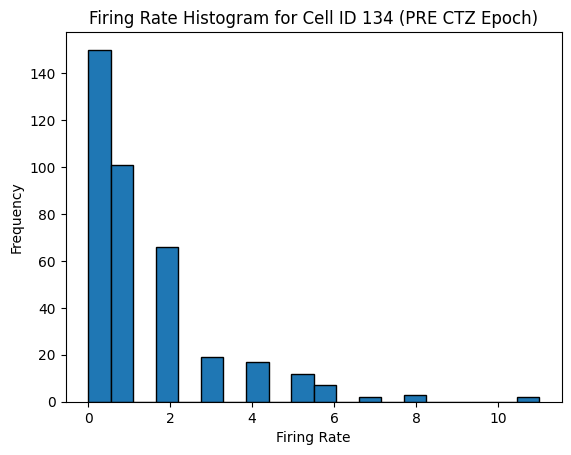

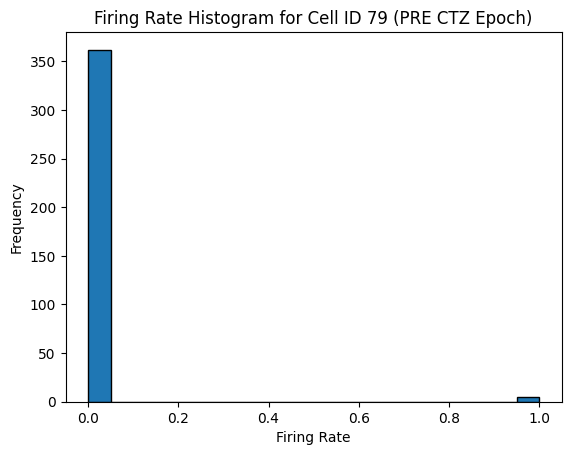

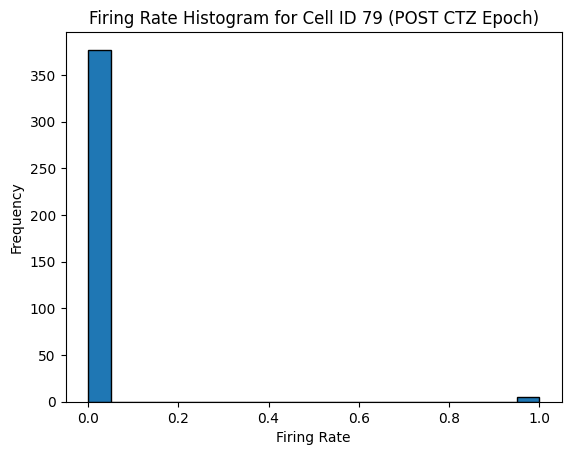

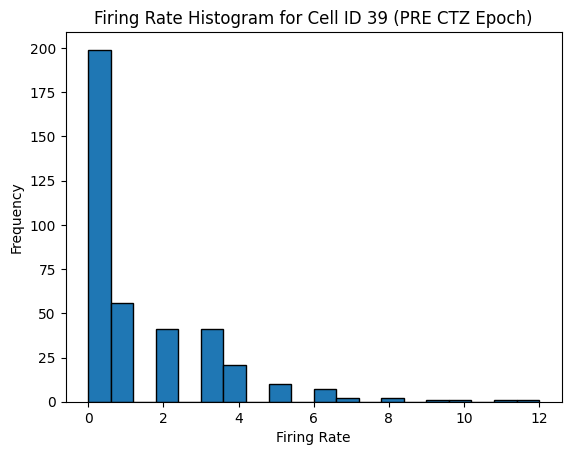

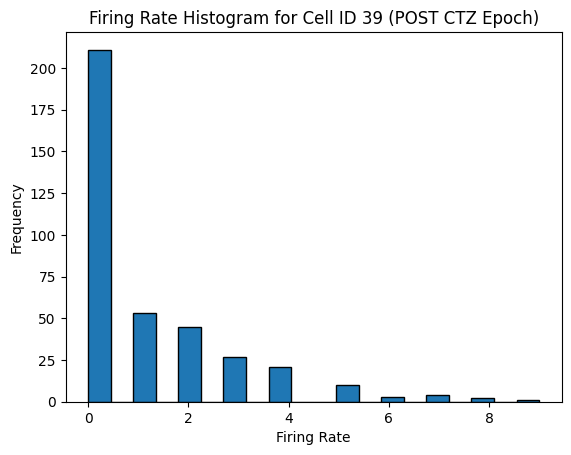

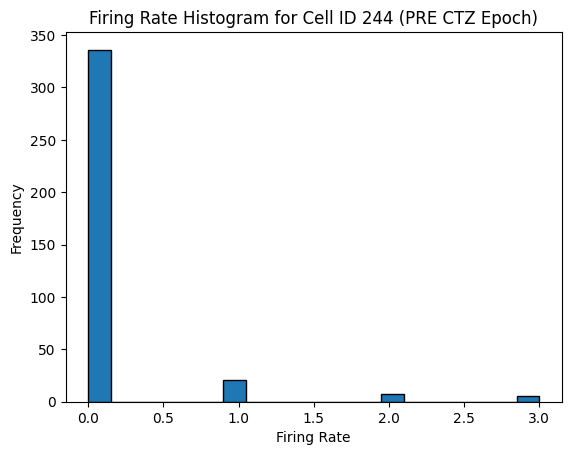

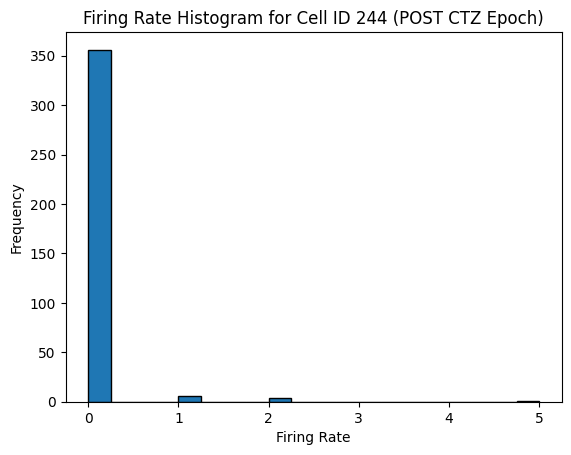

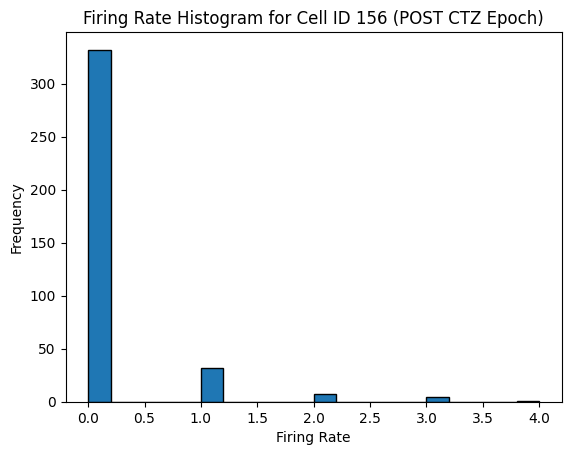

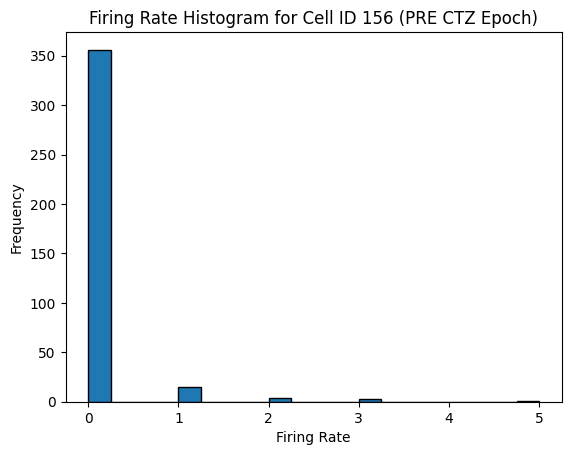

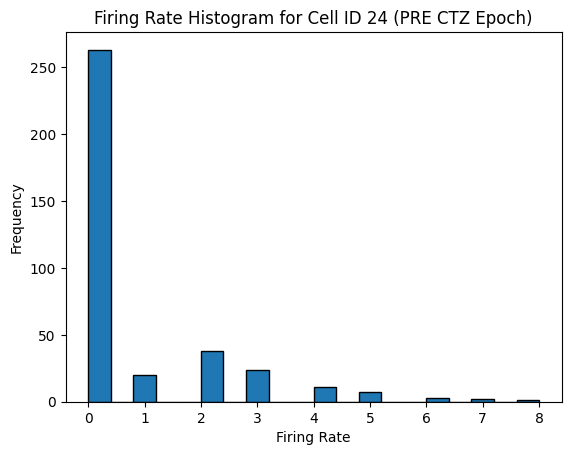

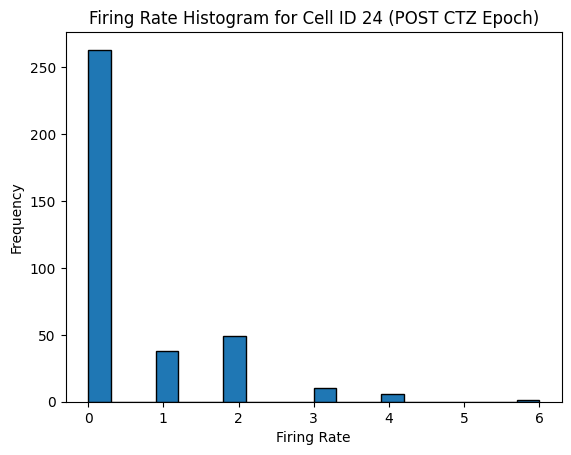

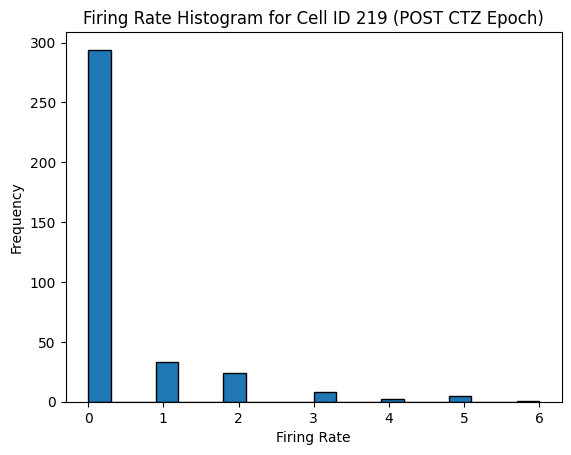

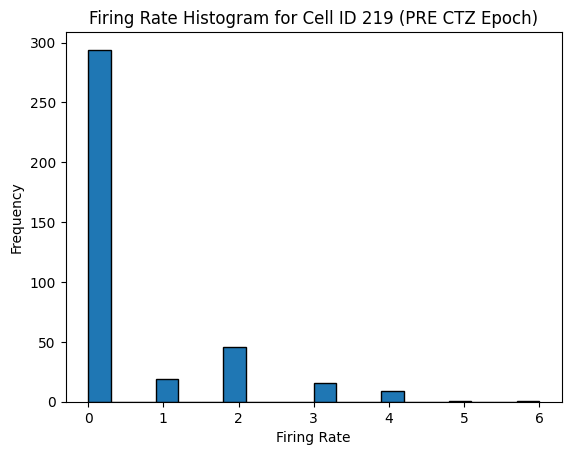

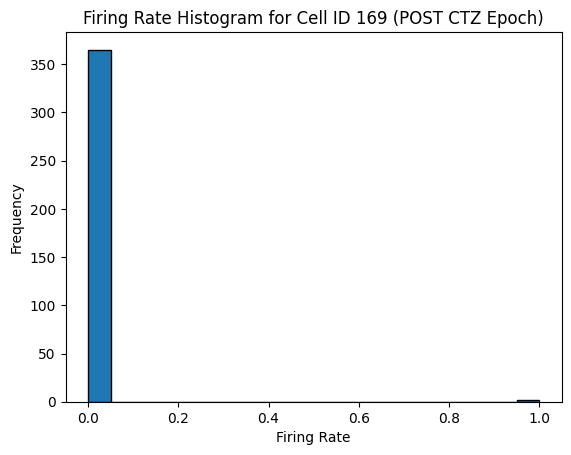

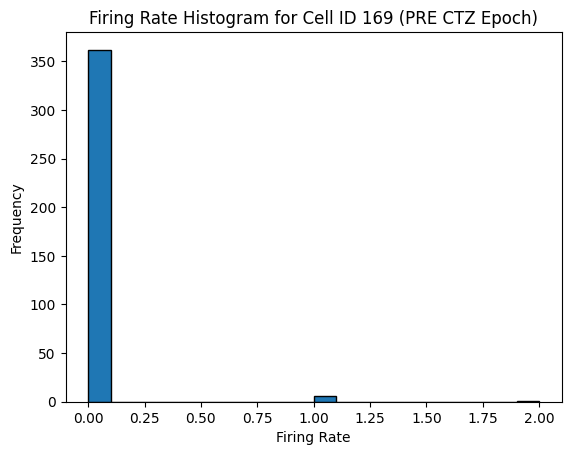

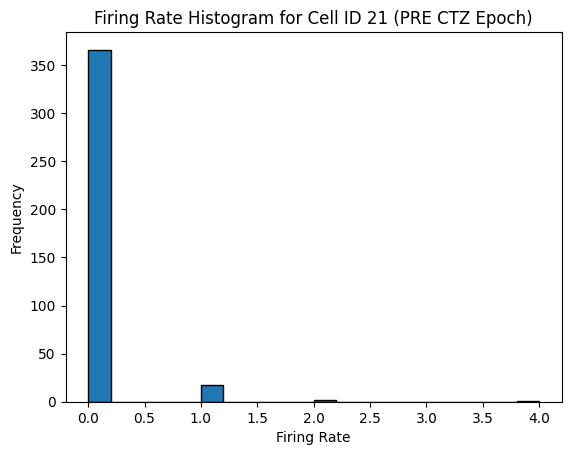

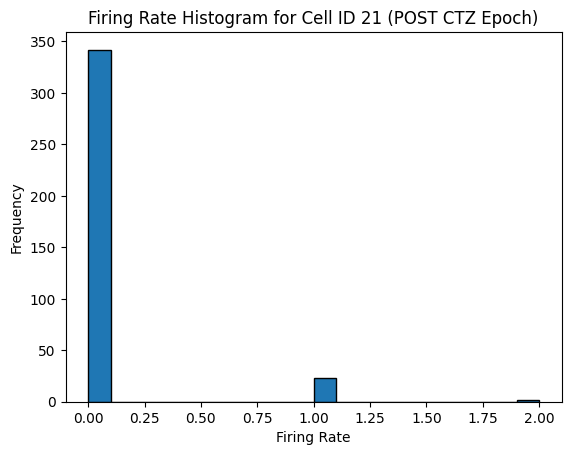

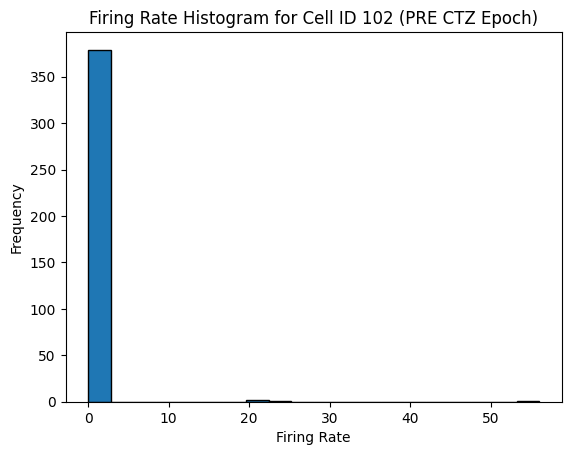

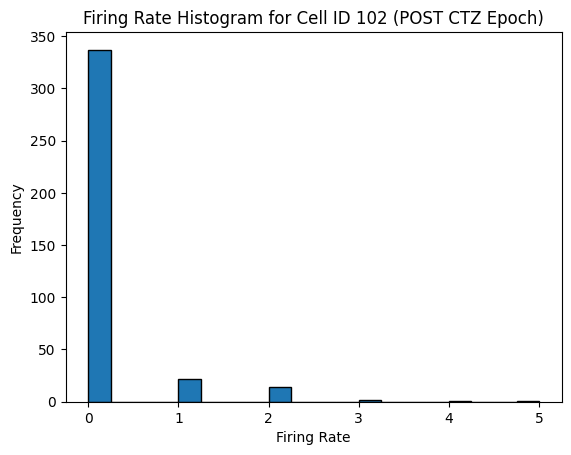

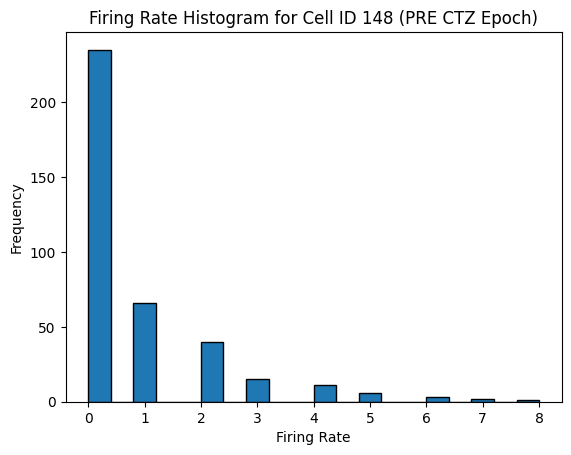

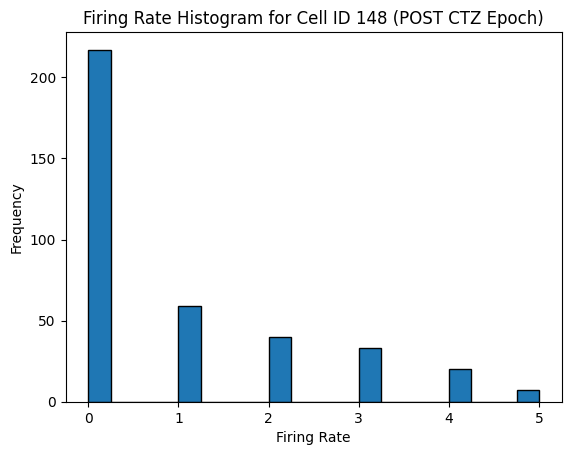

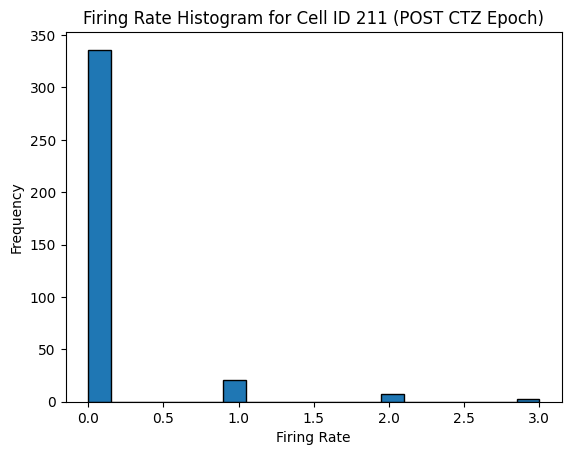

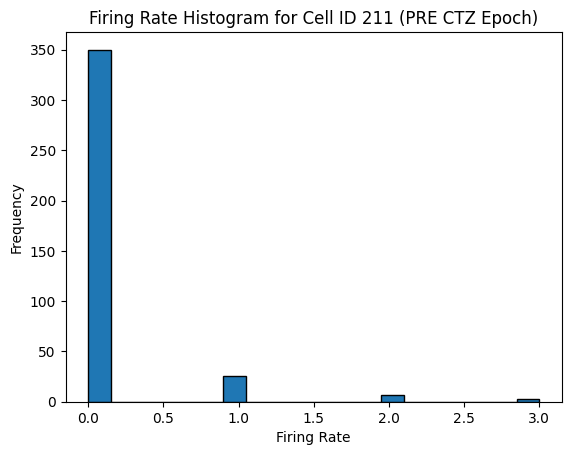

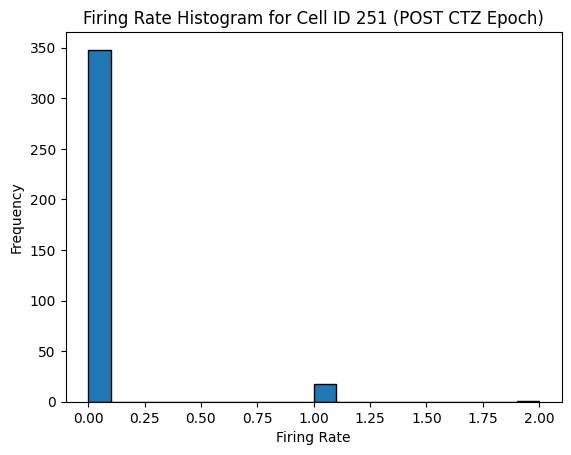

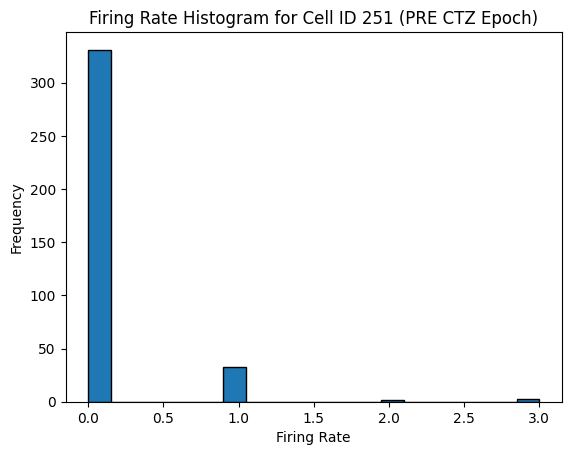

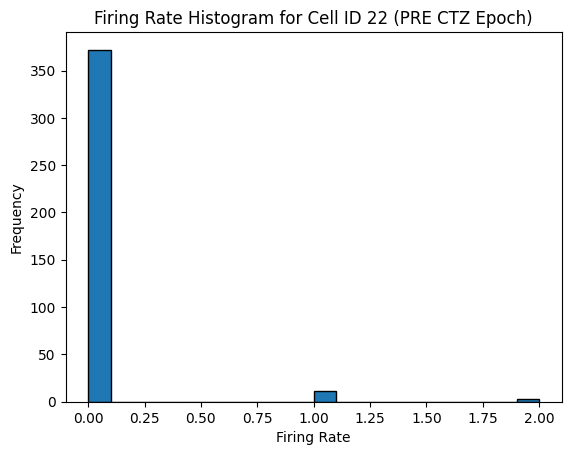

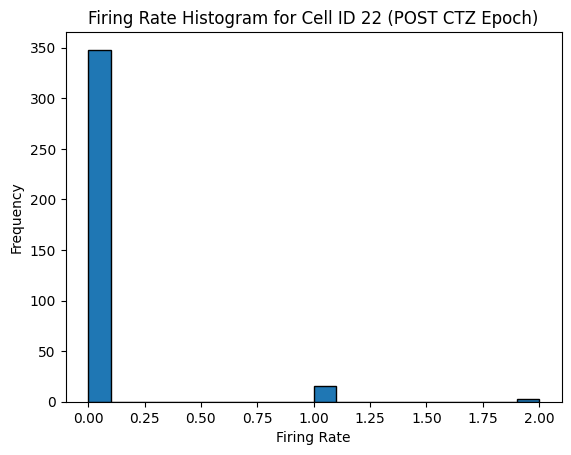

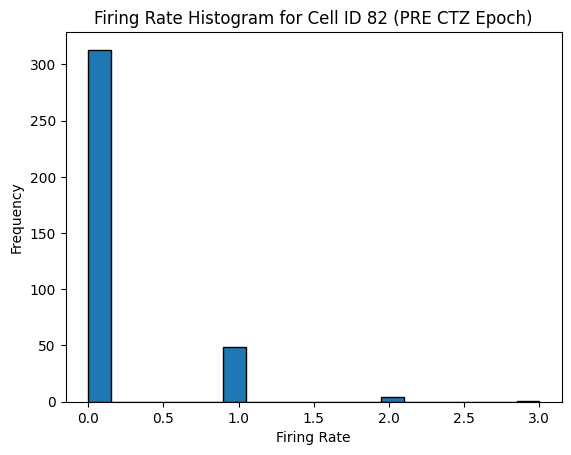

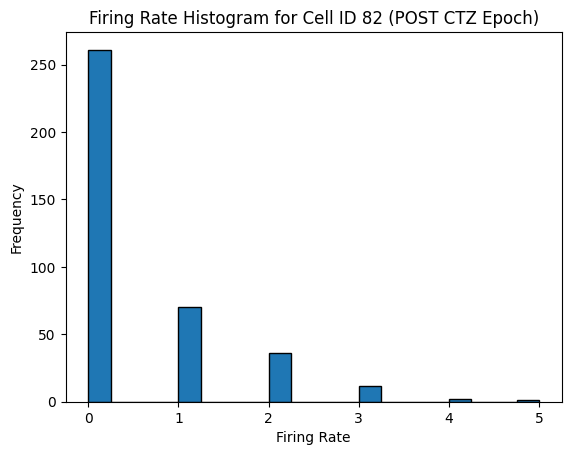

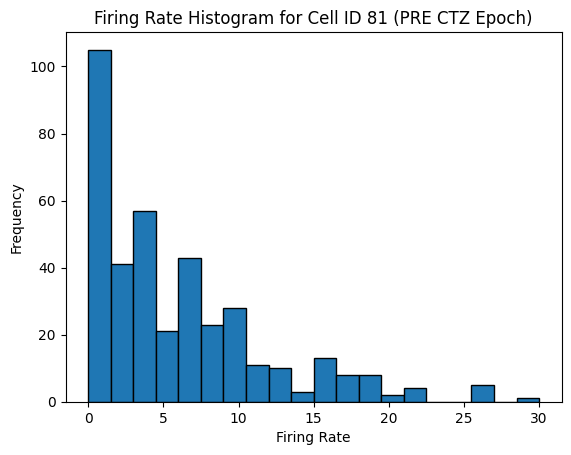

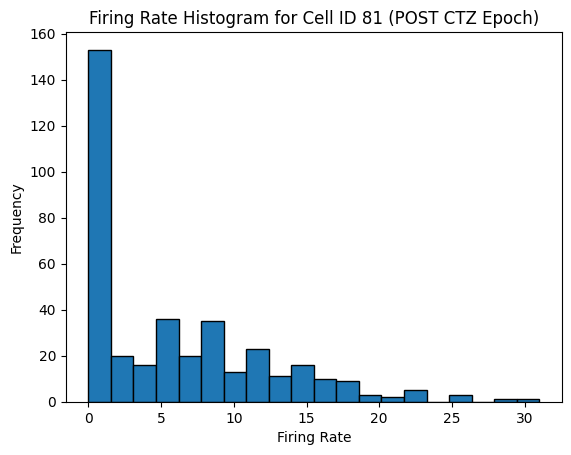

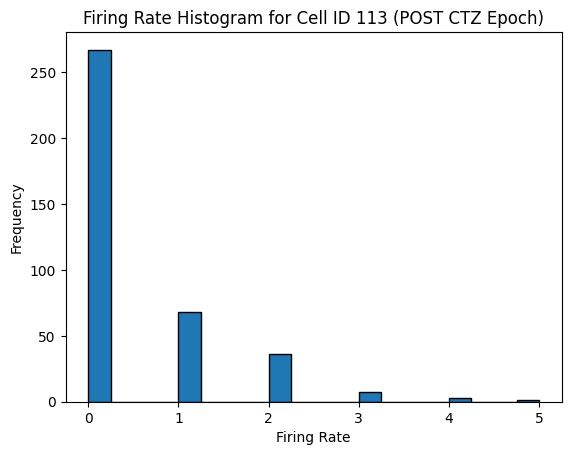

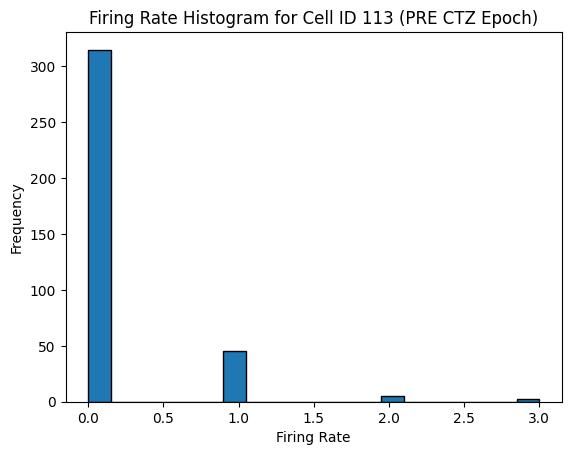

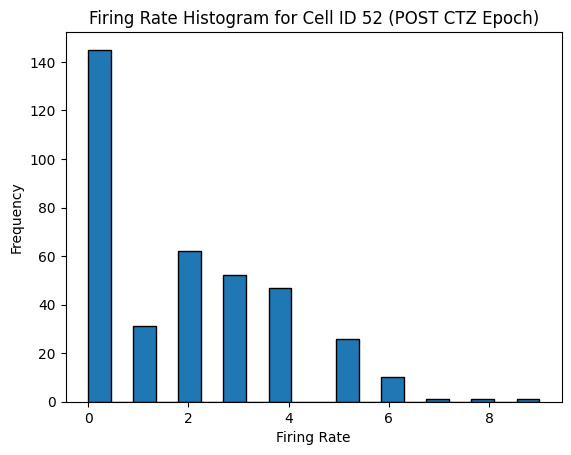

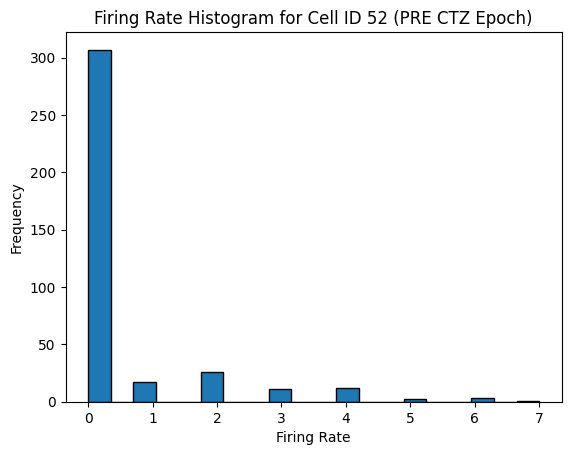

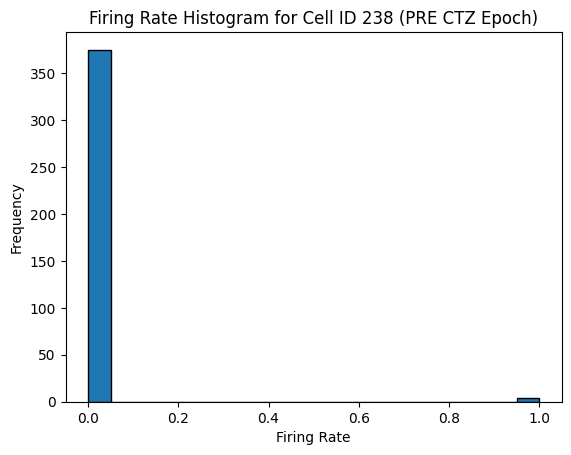

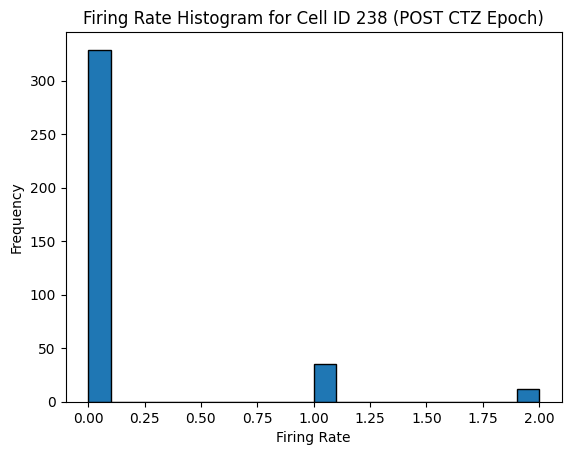

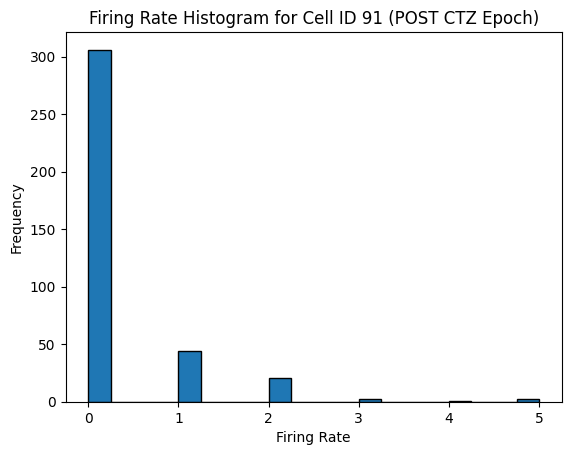

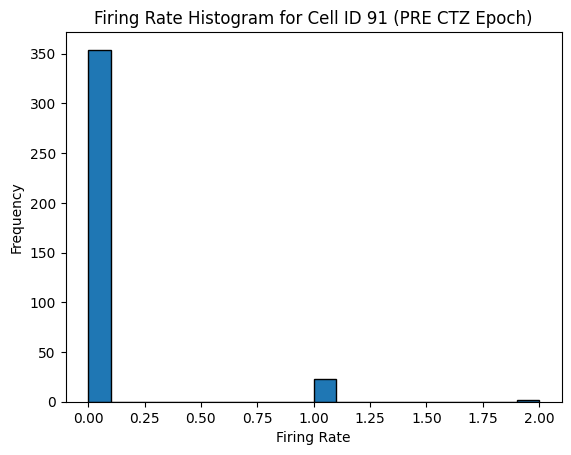

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict


input_directory = "/Users/cresp1el/Documents/lmc_project_analysis_dir/analysis_directory/combined_matrices_lowmidhigh"

import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict

def generate_histograms(directory):
    # Dictionary to store the files grouped by cell ID and CTZ condition
    cell_id_files = defaultdict(lambda: defaultdict(list))

    # Iterate through all .npy files in the specified directory and group by cell ID and CTZ condition
    for file_name in os.listdir(directory):
        if file_name.endswith("_combinedmatrix.npy"):
            # Extract the cell ID and CTZ condition from the file name
            parts = file_name.split("_")
            cell_id = parts[2]
            ctz_condition = parts[3]
            cell_id_files[cell_id][ctz_condition].append(os.path.join(directory, file_name))

    # Iterate through the unique cell IDs
    for cell_id, ctz_files in cell_id_files.items():
        # Iterate through the CTZ conditions (pre and post)
        for ctz_condition, files in ctz_files.items():
            # Initialize a list to store the firing rates for all trials for this cell ID and CTZ condition
            firing_rates = []

            # Iterate through the files for this cell ID and CTZ condition
            for file_path in files:
                # Load the .npy file
                matrix = np.load(file_path)

                # Extract the time window before whisker deflections (first 500 columns)
                pre_whisker_deflection = matrix[:, :500]

                # Compute the firing rate by summing the spikes across the time window for each trial
                firing_rate = pre_whisker_deflection.sum(axis=1)
                firing_rates.extend(firing_rate)

            # Plot the histogram of the firing rate for this cell ID and CTZ condition
            plt.hist(firing_rates, bins=20, edgecolor='black')
            plt.title(f"Firing Rate Histogram for Cell ID {cell_id} ({ctz_condition.upper()} CTZ Epoch)")
            plt.xlabel("Firing Rate")
            plt.ylabel("Frequency")
            plt.show()

# Generate histograms for the specified directory
generate_histograms(input_directory)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os

def generate_pooled_histograms(directory, bin_size=20, y_axis_cutoff=None):
    # Initialize lists to store the firing rates for all pre and post CTZ trials
    firing_rates_pre = []
    firing_rates_post = []

    # Iterate through all .npy files in the specified directory
    for file_name in os.listdir(directory):
        if file_name.endswith("_combinedmatrix.npy"):
            # Extract the CTZ condition from the file name
            ctz_condition = file_name.split("_")[3]

            file_path = os.path.join(directory, file_name)

            # Load the .npy file
            matrix = np.load(file_path)

            # Extract the time window before whisker deflections (first 500 columns)
            pre_whisker_deflection = matrix[:, :500]

            # Compute the firing rate by summing the spikes across the time window for each trial
            firing_rate = pre_whisker_deflection.sum(axis=1)

            # Append the firing rates to the appropriate list based on the CTZ condition
            if ctz_condition == "pre":
                firing_rates_pre.extend(firing_rate)
            elif ctz_condition == "post":
                firing_rates_post.extend(firing_rate)

    # Function to plot the histogram with the specified bin size and y-axis cutoff
    def plot_histogram(data, title):
        plt.hist(data, bins=bin_size, edgecolor='black')
        plt.title(title)
        plt.xlabel("Firing Rate")
        plt.ylabel("Frequency")
        if y_axis_cutoff:
            plt.ylim(0, y_axis_cutoff) # Set the y-axis limits from 0 to the specified cutoff
        plt.show()

    # Plot the histograms for pre and post CTZ trials
    plot_histogram(firing_rates_pre, "Firing Rate Histogram for Pre CTZ Epoch")
    plot_histogram(firing_rates_post, "Firing Rate Histogram for Post CTZ Epoch")

# Generate the pooled histograms for the pre and post CTZ trials
generate_pooled_histograms(input_directory, bin_size=50, y_axis_cutoff=200)

NameError: name 'input_directory' is not defined

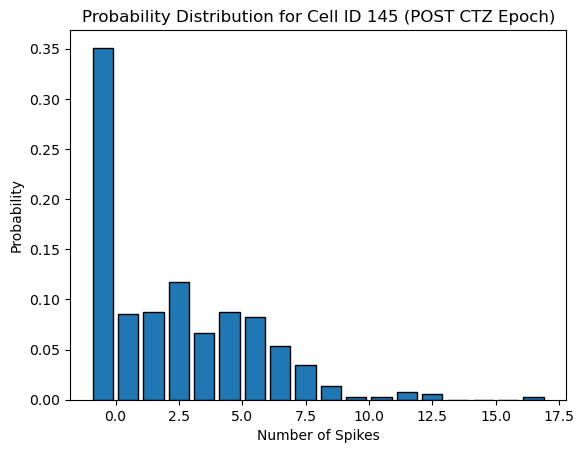

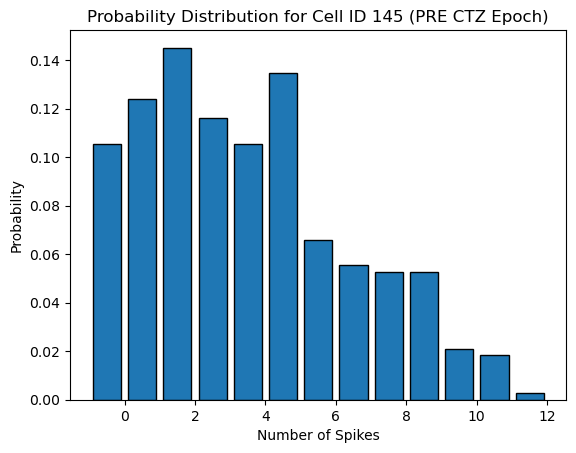

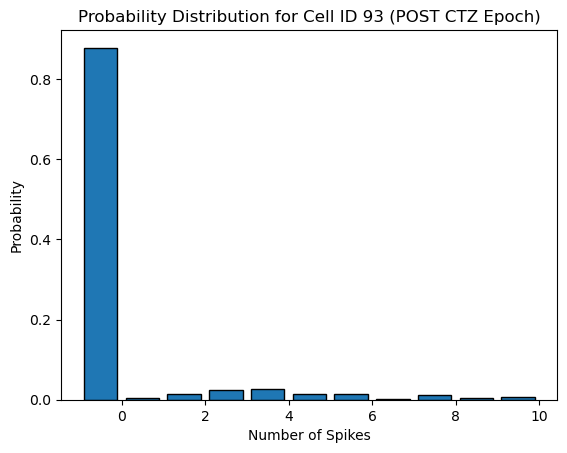

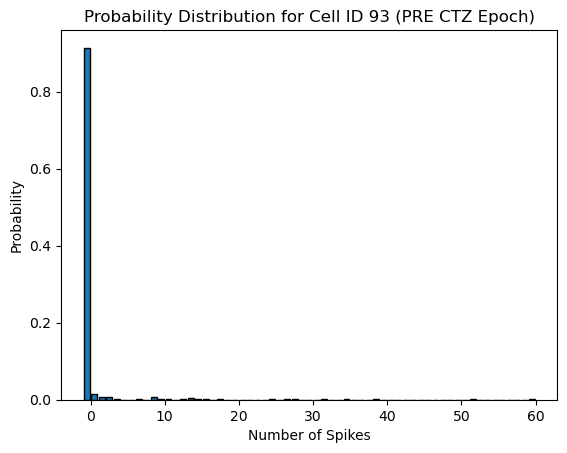

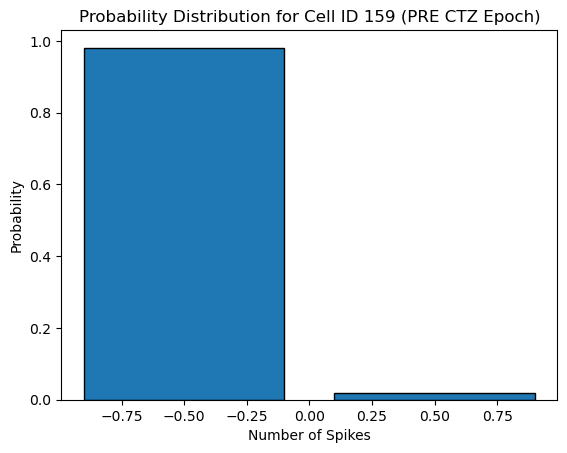

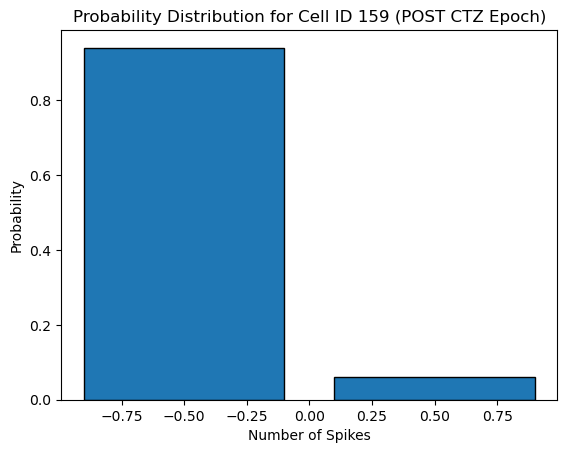

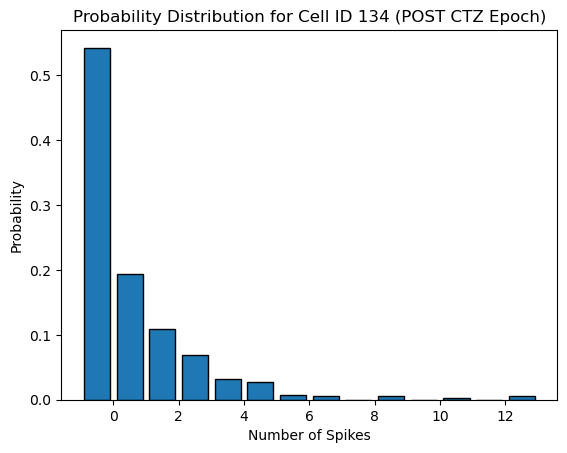

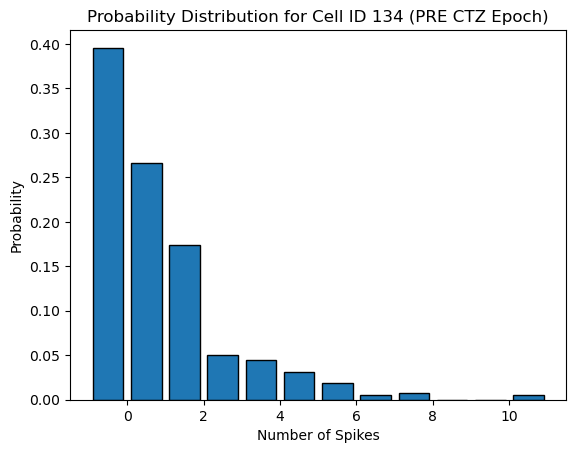

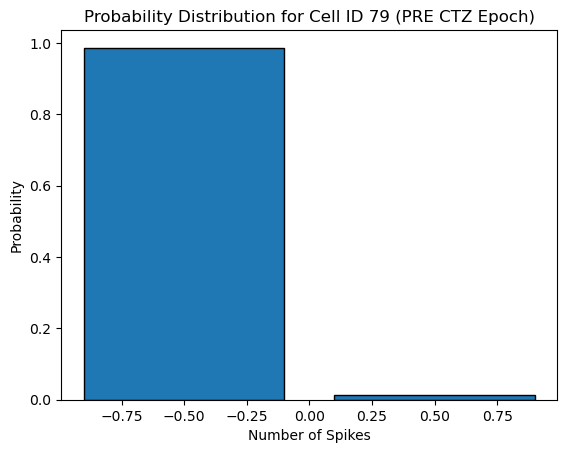

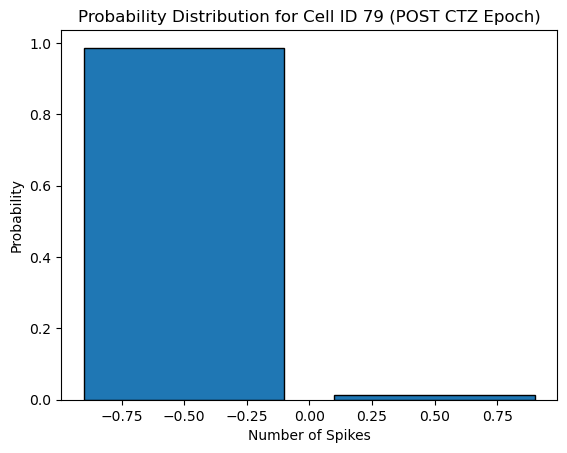

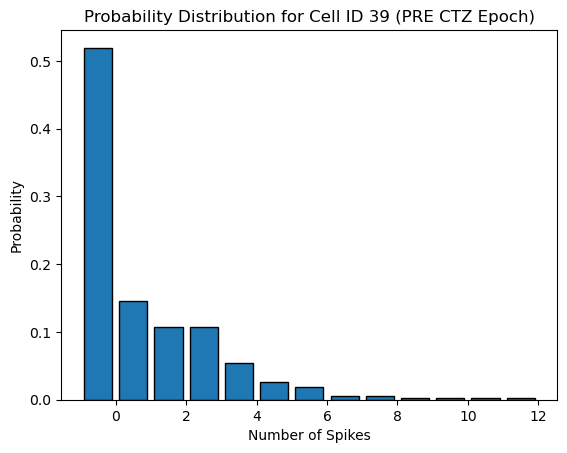

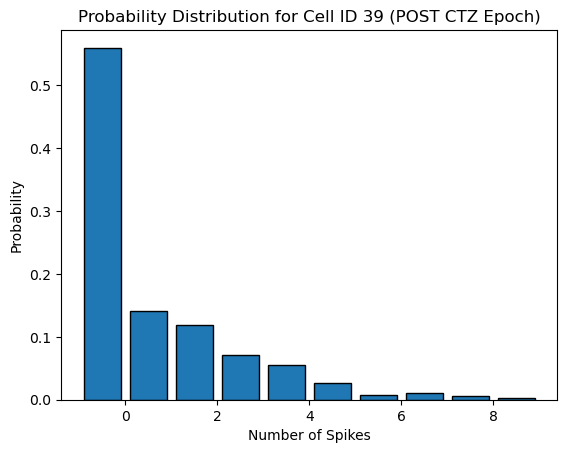

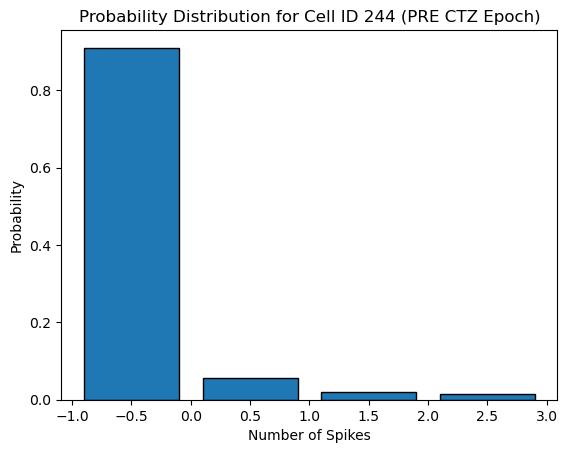

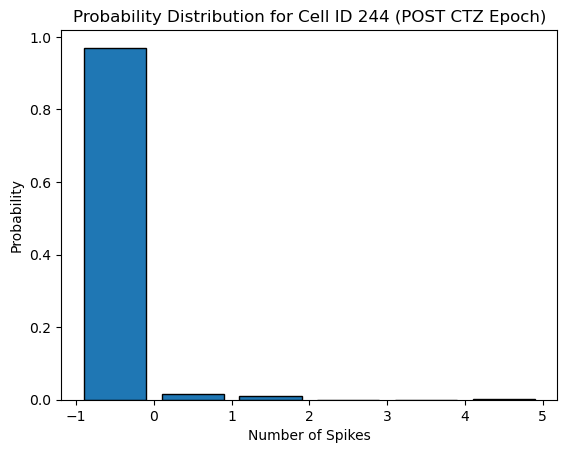

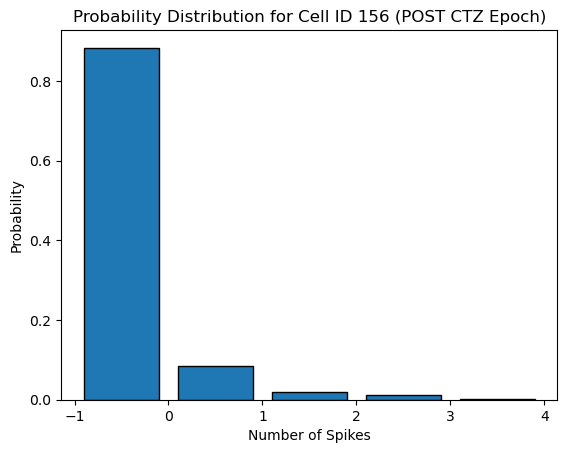

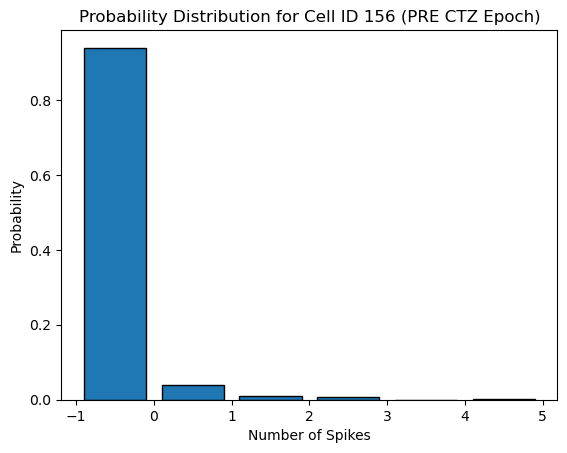

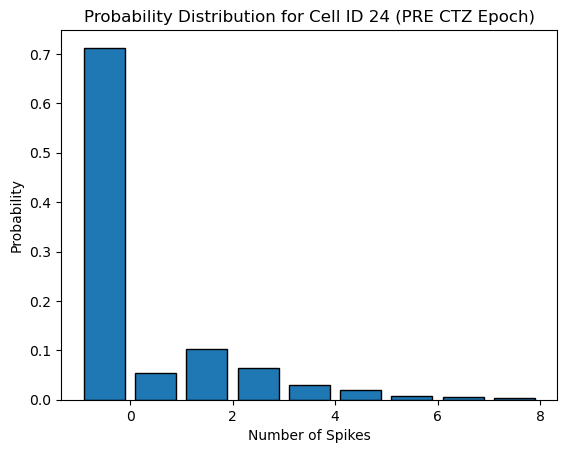

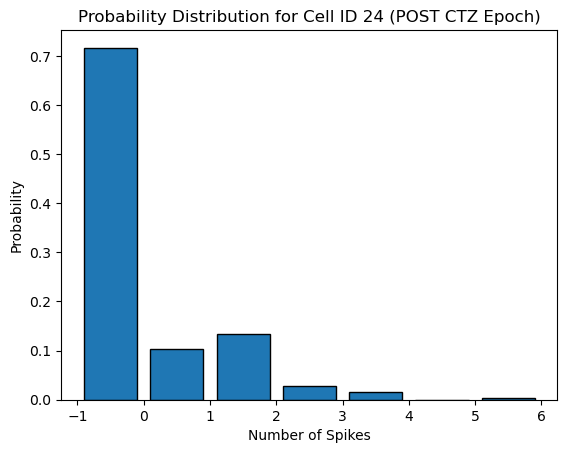

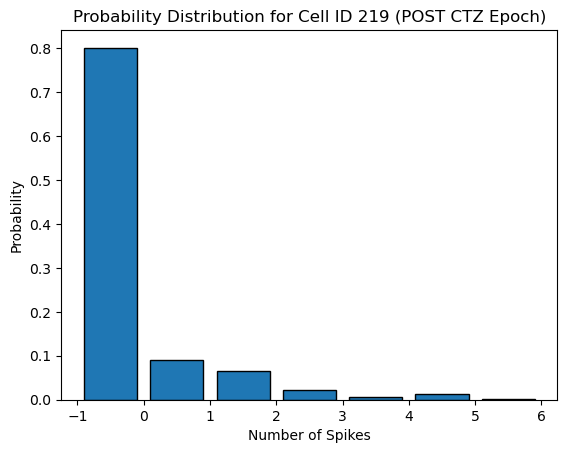

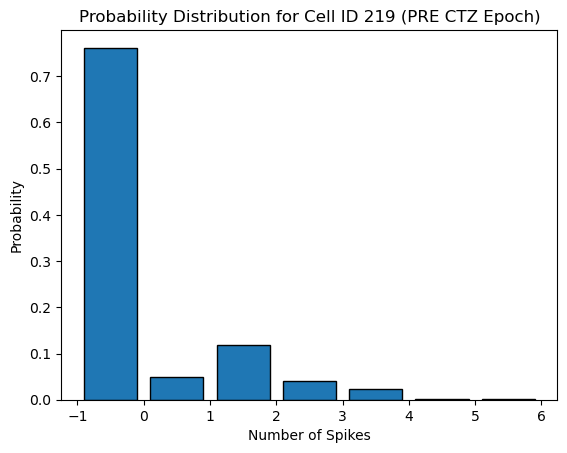

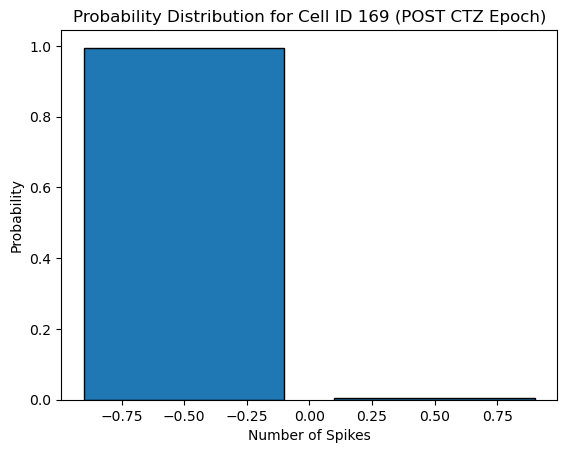

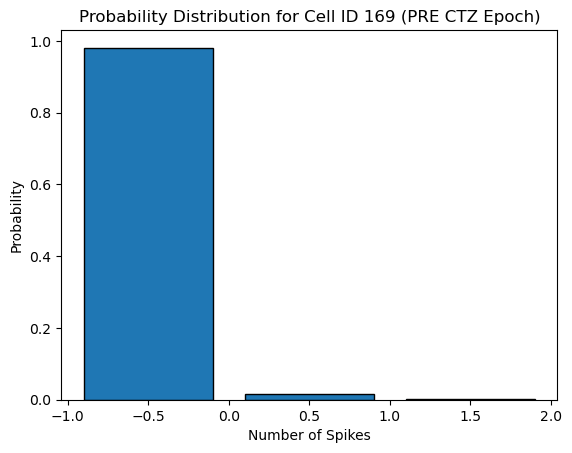

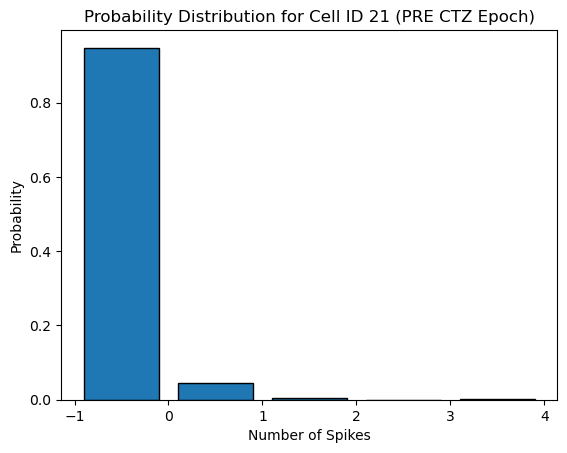

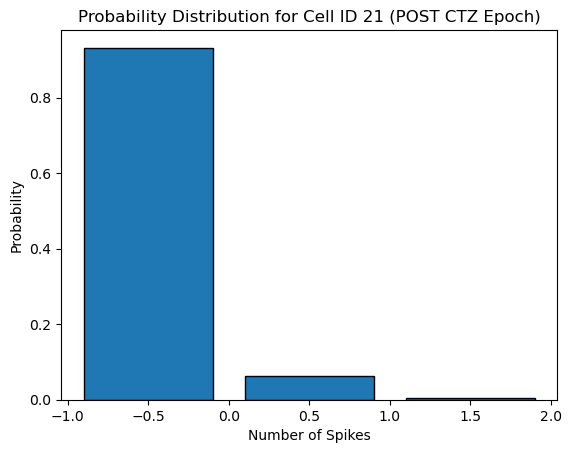

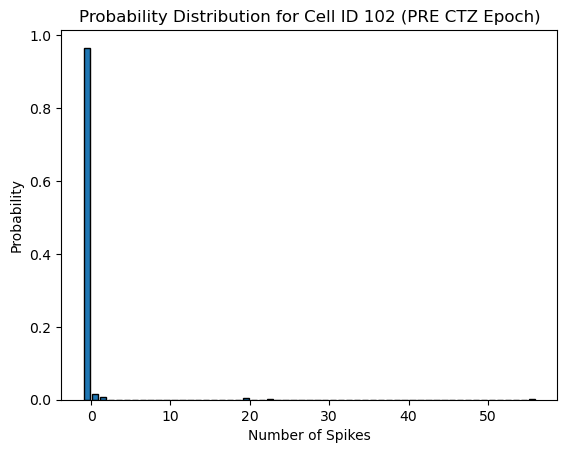

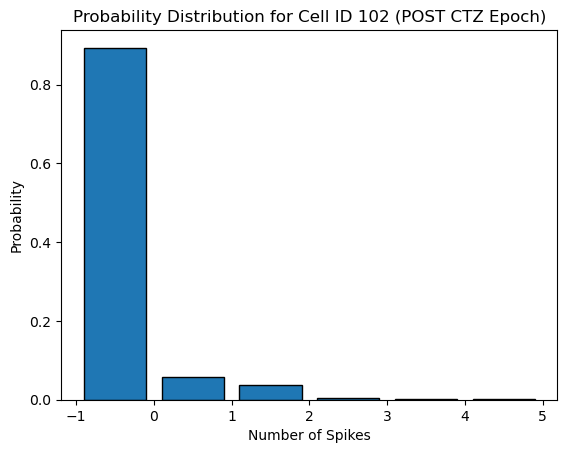

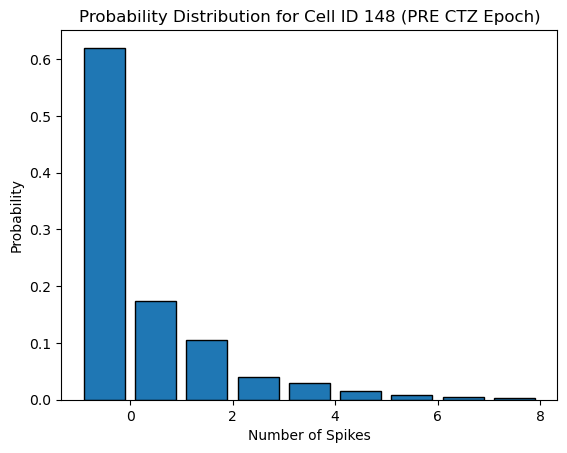

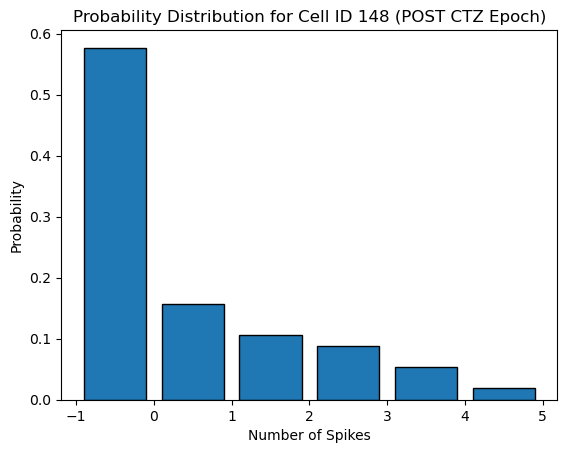

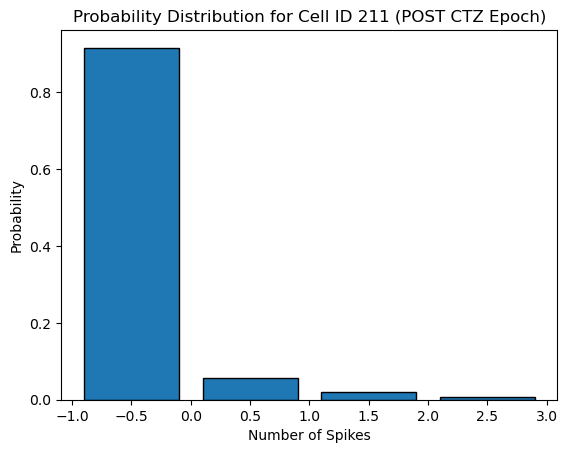

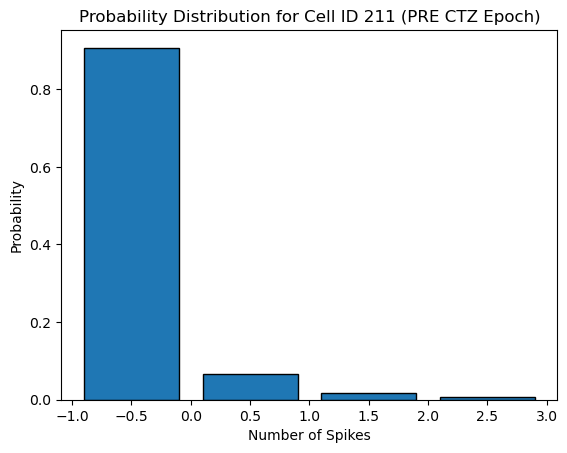

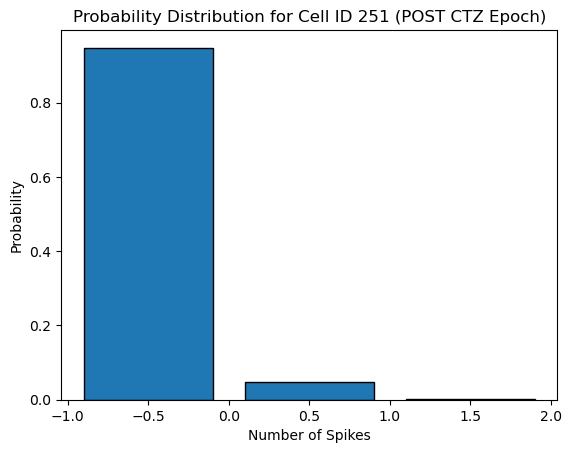

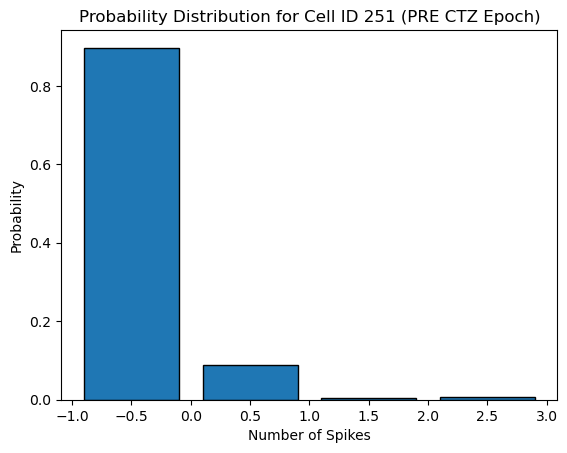

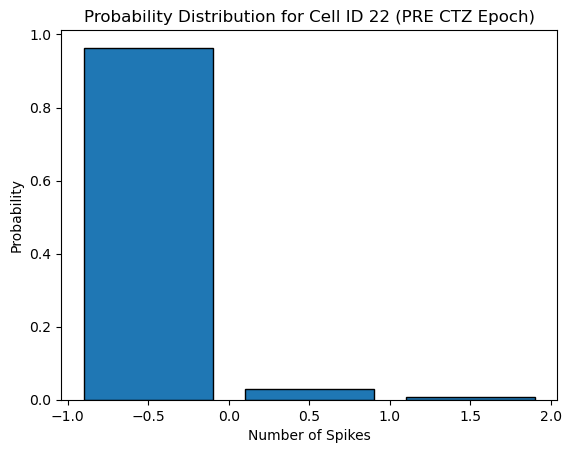

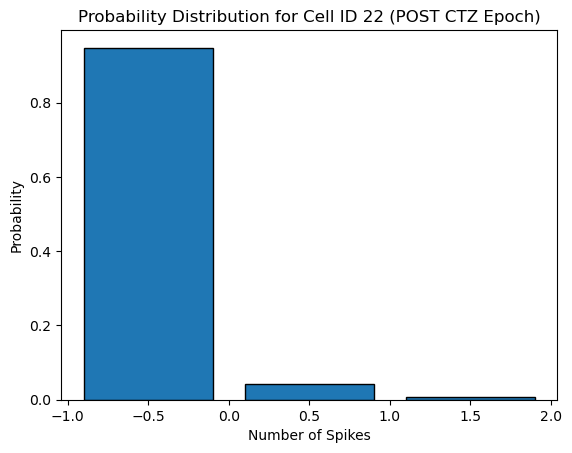

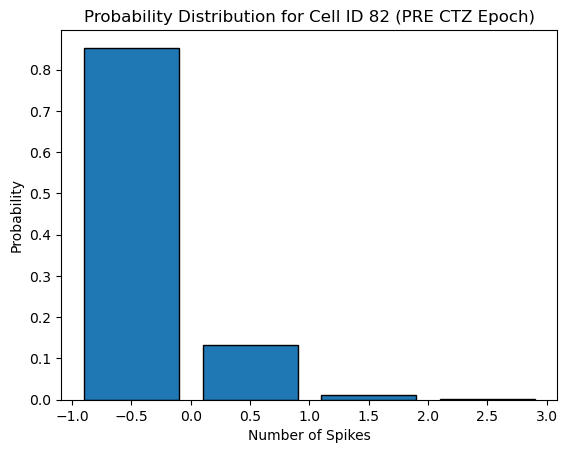

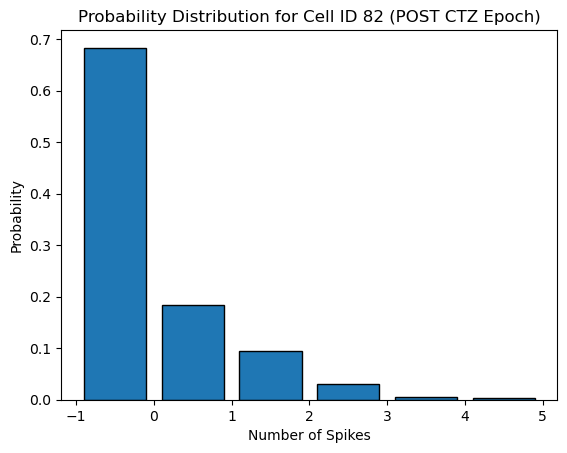

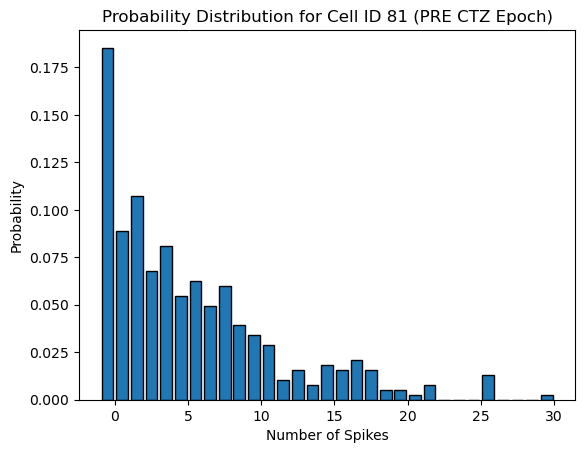

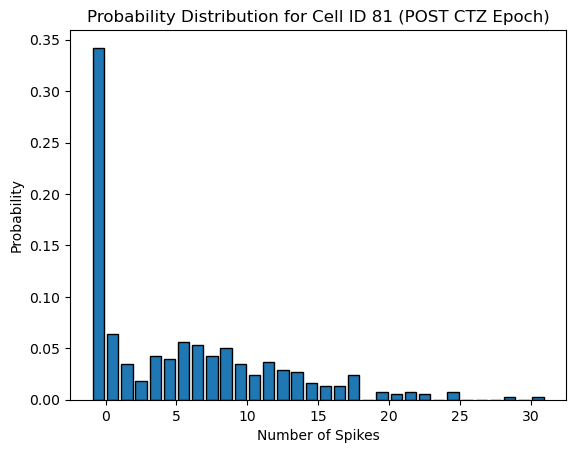

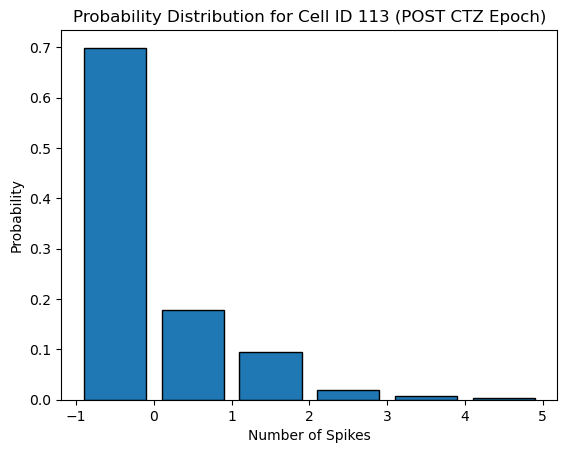

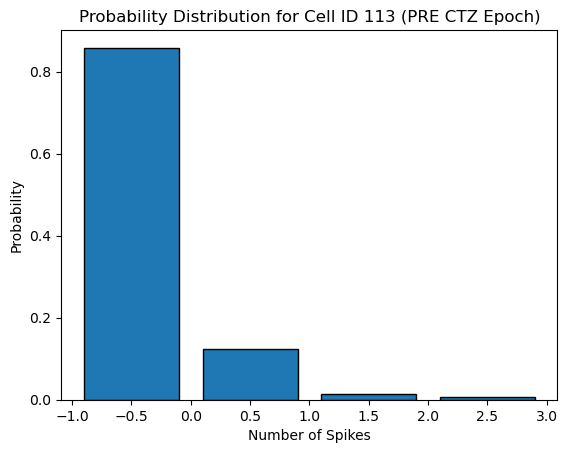

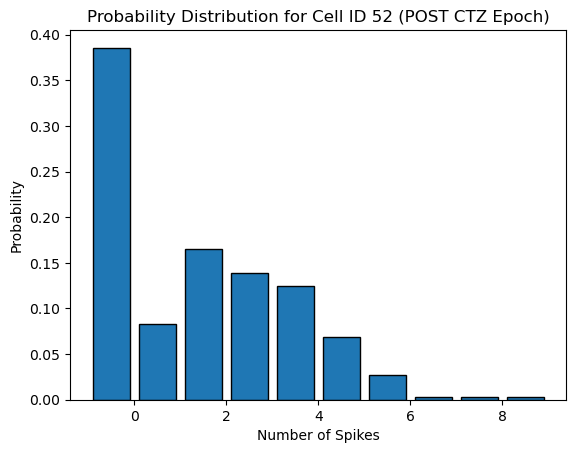

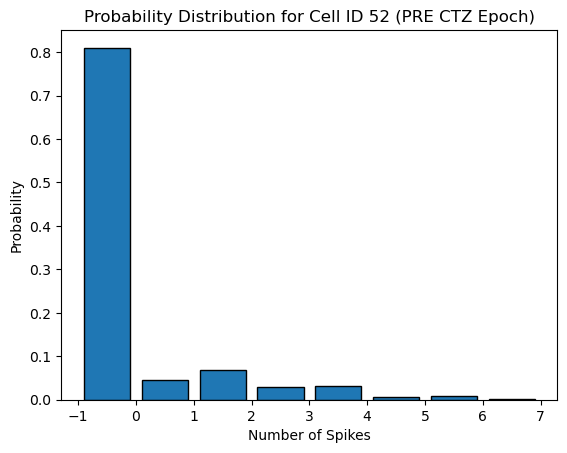

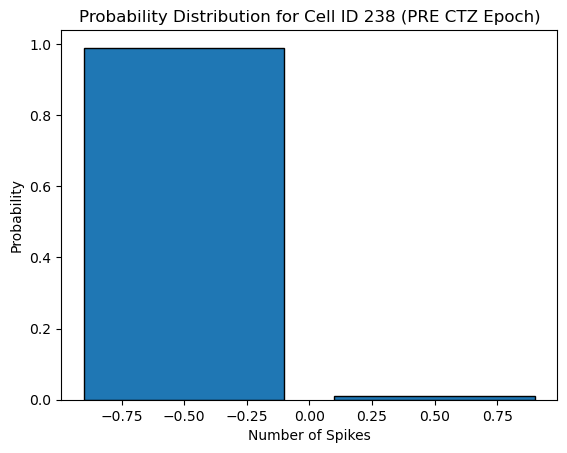

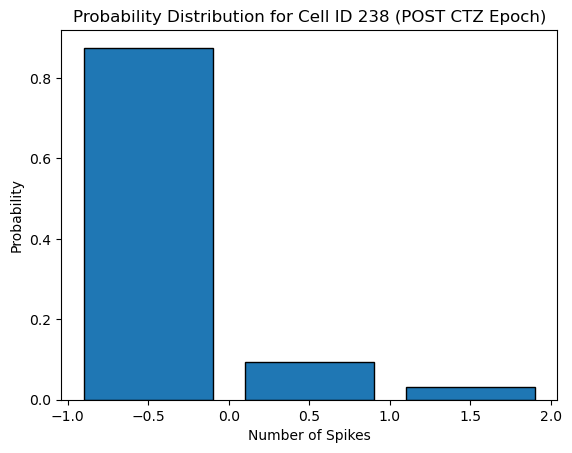

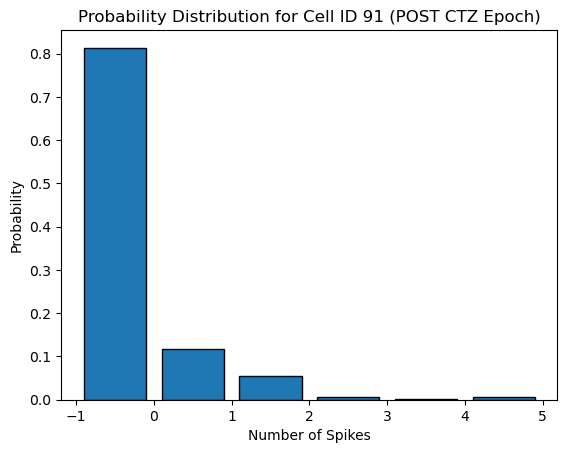

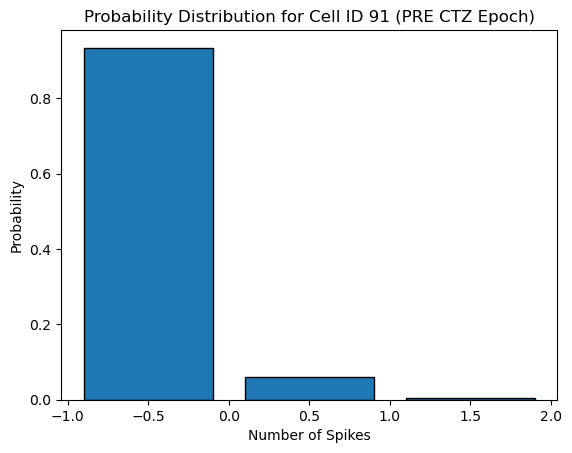

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict

def generate_probability_histograms(directory):
    # Dictionary to store the files grouped by cell ID and CTZ condition
    cell_id_files = defaultdict(lambda: defaultdict(list))

    # Iterate through all .npy files in the specified directory and group by cell ID and CTZ condition
    for file_name in os.listdir(directory):
        if file_name.endswith("_combinedmatrix.npy"):
            # Extract the cell ID and CTZ condition from the file name
            parts = file_name.split("_")
            cell_id = parts[2]
            ctz_condition = parts[3]
            cell_id_files[cell_id][ctz_condition].append(os.path.join(directory, file_name))

    # Iterate through the unique cell IDs
    for cell_id, ctz_files in cell_id_files.items():
        # Iterate through the CTZ conditions (pre and post)
        for ctz_condition, files in ctz_files.items():
            # Iterate through the files for this cell ID and CTZ condition
            for file_path in files:
                # Load the .npy file
                matrix = np.load(file_path)

                # Extract the time window before whisker deflections (first 500 columns)
                pre_whisker_deflection = matrix[:, :500]

                # Count the number of spikes in each trial
                spike_counts = pre_whisker_deflection.sum(axis=1)

                # Compute the histogram counts and bin edges
                hist_counts, bin_edges = np.histogram(spike_counts, bins=np.arange(spike_counts.max() + 2) - 0.5)

                # Normalize the counts to form a probability distribution
                probabilities = hist_counts / hist_counts.sum()

                # Plot the probability distribution histogram
                plt.bar(bin_edges[:-1], probabilities, width=0.8, edgecolor='black')
                plt.title(f"Probability Distribution for Cell ID {cell_id} ({ctz_condition.upper()} CTZ Epoch)")
                plt.xlabel("Number of Spikes")
                plt.ylabel("Probability")
                plt.show()

generate_probability_histograms(input_directory)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict

def generate_probability_histograms(directory):
    # Dictionary to store the files grouped by group ID, mouse ID, cell ID, and CTZ condition
    cell_id_files = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list))))

    # Iterate through all .npy files in the specified directory and group by group ID, mouse ID, cell ID, and CTZ condition
    for file_name in os.listdir(directory):
        if file_name.endswith("_combinedmatrix.npy"):
            # Extract the group ID, mouse ID, cell ID, and CTZ condition from the file name
            parts = file_name.split("_")
            group_id = parts[0]
            mouse_id = parts[1]
            cell_id = parts[2]
            ctz_condition = parts[3]
            cell_id_files[group_id][mouse_id][cell_id][ctz_condition].append(os.path.join(directory, file_name))

    # Iterate through the unique group IDs, mouse IDs, and cell IDs
    for group_id, mouse_files in cell_id_files.items():
        for mouse_id, cell_files in mouse_files.items():
            for cell_id, ctz_files in cell_files.items():
                # Create a 1x2 subplot for this group ID, mouse ID, and cell ID
                fig, axes = plt.subplots(1, 2, figsize=(12, 5))

                # Ensure that the pre CTZ epoch is on the left and the post CTZ epoch is on the right
                for ctz_condition, color in zip(['pre', 'post'], ['grey', 'blue']):
                    file_path = ctz_files[ctz_condition][0]  # Assuming there's only one file per condition
                    # Load the .npy file
                    matrix = np.load(file_path)

                    # Extract the time window before whisker deflections (first 500 columns)
                    pre_whisker_deflection = matrix[:, :500]

                    # Count the number of spikes in each trial
                    spike_counts = pre_whisker_deflection.sum(axis=1)

                    # Compute the histogram counts and bin edges
                    hist_counts, bin_edges = np.histogram(spike_counts, bins=np.arange(spike_counts.max() + 2))

                    # Normalize the counts to form a probability distribution
                    probabilities = hist_counts / hist_counts.sum()

                    # Plot the probability distribution histogram with the specified color
                    i = 0 if ctz_condition == 'pre' else 1
                    axes[i].bar(bin_edges[:-1], probabilities, width=0.8, edgecolor='black', color=color)
                    axes[i].set_title(f"{ctz_condition.upper()} CTZ Epoch")
                    axes[i].set_xlabel("Number of Spikes")
                    axes[i].set_ylabel("Probability")

                # Set a main title for the entire subplot, including the group ID, mouse ID, and cell ID
                plt.suptitle(f"Probability Distribution for Group {group_id}, Mouse {mouse_id}, Cell ID {cell_id}")
                plt.tight_layout(rect=[0, 0, 1, 0.96])
                plt.show()


generate_probability_histograms(input_directory)

NameError: name 'input_directory' is not defined

The generate_group_probability_histograms function is designed to create overlaid histograms showing the probability distribution of spike counts for different experimental conditions. This will create overlaid histograms for each group, showing the probability distribution of spike counts for the PRE and POST CTZ epochs.

Description

Load Data: The function reads the data from .npy files located in a specified directory. Each file represents a 2D numpy matrix where rows are trials, and columns represent a 1ms time window in binarized data format.
Data Processing: The function processes the data according to different conditions (PRE and POST CTZ) and groups (opsin and noopsin). It sums the spike counts within a specified time window for each trial.
Create Histograms: The function computes histograms for each condition and group, showing the probability distribution of the number of spikes.
Plotting: The histograms for the PRE and POST CTZ epochs are plotted on the same figure for each group, with the bars filled white and edges colored grey or blue.

Parameters
directory (str): The path to the directory containing the .npy files.
yaxis_cutoff (float, optional): A value to set the y-axis limit for better visualization. If not provided, the y-axis will autoscale.
bin_size (int, optional): The size of the bins in the histogram. If not provided, an automatic bin size is used.
time_window (tuple, optional): A tuple specifying the start and end of the time window (in milliseconds) within which to sum the spikes. Defaults to (0, 500).

Requirements
The specified directory must contain .npy files named according to the pattern GROUPID_MOUSEID_CELLID_CTZCONDITION_combinedmatrix.npy, where GROUPID is "opsin" or "noopsin", and CTZCONDITION is "pre" or "post".
The .npy files must contain 2D numpy matrices with the appropriate data format.


Notes
Ensure that the .npy files are named according to the expected pattern and contain the correct data format.
Adjust the optional parameters (yaxis_cutoff, bin_size, time_window) as needed for your specific analysis.

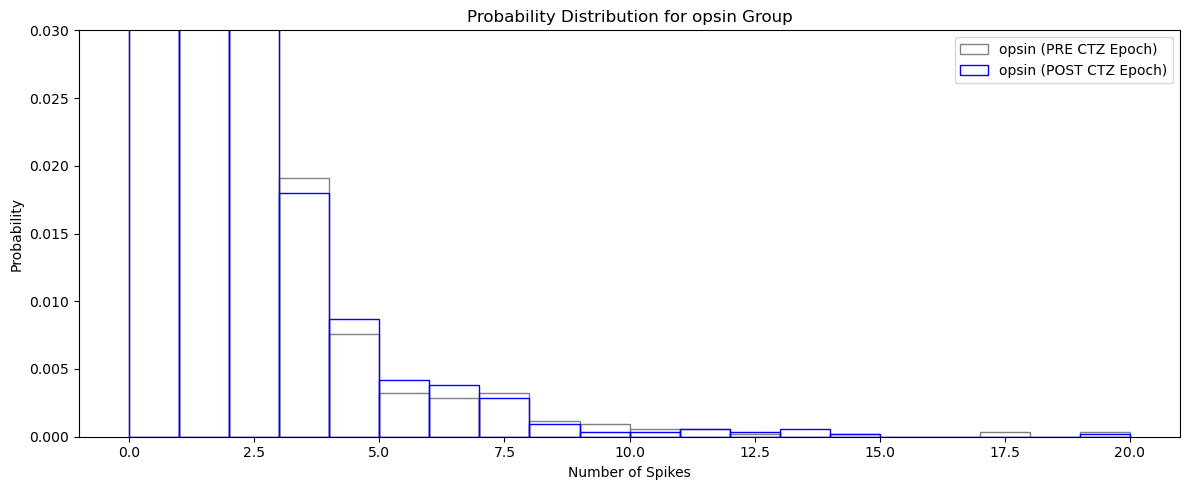

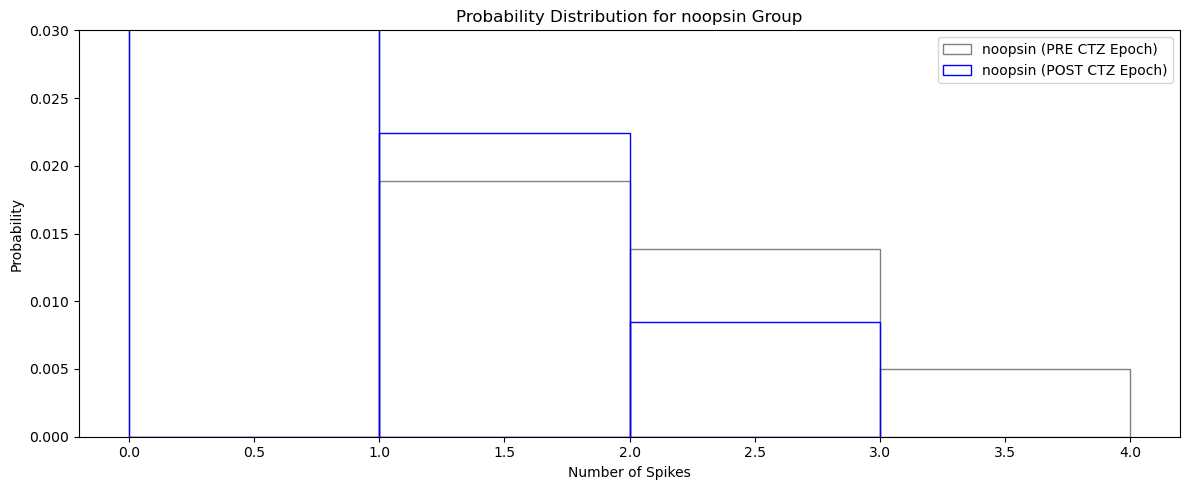

In [17]:
def generate_group_probability_histograms(directory, yaxis_cutoff=None, bin_size=None, time_window=(0, 500)):
    spike_counts_dict = defaultdict(lambda: defaultdict(list))
    window_start, window_end = time_window

    # Iterate through all .npy files in the specified directory
    for file_name in os.listdir(directory):
        if file_name.endswith("_combinedmatrix.npy"):
            parts = file_name.split("_")
            group_id = parts[0]  # "opsin" or "noopsin"
            ctz_condition = parts[3]
            file_path = os.path.join(directory, file_name)
            matrix = np.load(file_path)
            custom_window = matrix[:, window_start:window_end]
            spike_counts = custom_window.sum(axis=1)
            spike_counts_dict[group_id][ctz_condition].extend(spike_counts)

    def plot_histogram(ax, spike_counts, edge_color, label, bin_size):
        bins = np.arange(0, max(spike_counts) + 1, bin_size) if bin_size else 'auto'
        hist_counts, bin_edges = np.histogram(spike_counts, bins=bins)
        probabilities = hist_counts / hist_counts.sum()
        ax.bar(bin_edges[:-1], probabilities, width=bin_size if bin_size else 1, edgecolor=edge_color, facecolor='none', align='edge')
        ax.set_xlabel("Number of Spikes")
        ax.set_ylabel("Probability")
        if yaxis_cutoff:
            ax.set_ylim(0, yaxis_cutoff)

    # Iterate through the unique groups (opsin and noopsin)
    for group_id, ctz_files in spike_counts_dict.items():
        fig, ax = plt.subplots(figsize=(12, 5))
        plot_histogram(ax, ctz_files['pre'], 'grey', f"{group_id} (PRE CTZ Epoch)", bin_size)
        plot_histogram(ax, ctz_files['post'], 'blue', f"{group_id} (POST CTZ Epoch)", bin_size)
        ax.legend([f"{group_id} (PRE CTZ Epoch)", f"{group_id} (POST CTZ Epoch)"])
        plt.title(f"Probability Distribution for {group_id} Group")
        plt.tight_layout()
        plt.show()

yaxis_cutoff = 0.03  # Optional: Define the y-axis cut-off
bin_size = 1        # Optional: Define the bin size
time_window = (350, 500) # Optional: Define the time window

generate_group_probability_histograms(input_directory, yaxis_cutoff, bin_size, time_window)


Description

The generate_cell_probability_histograms function generates individual overlaid histograms for each unique combination of cell ID, mouse ID, and group (e.g., "opsin" or "noopsin"). It shows the probability distribution of the number of spikes for PRE and POST CTZ epochs, performing the following steps:

Load Data: Reads the data from .npy files located in the specified directory.
Data Processing: Processes the data according to different groups, mouse IDs, cell IDs, and conditions (PRE and POST CTZ). It sums the spike counts within a specified time window for each trial.
Create Histograms: Computes histograms for each unique combination, showing the probability distribution of the number of spikes.
Plotting: Plots individual overlaid histograms for each unique combination with bars filled white and edges colored grey or blue.

Parameters

directory (str): The path to the directory containing the .npy files.
yaxis_cutoff (float, optional): A value to set the y-axis limit for better visualization. If not provided, the y-axis will autoscale.
bin_size (int, optional): The size of the bins in the histogram. If not provided, an automatic bin size is used.
time_window (tuple, optional): A tuple specifying the start and end of the time window (in milliseconds) within which to sum the spikes. Defaults to (0, 500).
exclude_zero_spikes (bool, optional): If set to True, the bin corresponding to 0 spikes will be excluded from the histogram. Defaults to False.

Requirements
The specified directory must contain .npy files named according to the pattern GROUPID_MOUSEID_CELLID_CTZCONDITION_combinedmatrix.npy.
The .npy files must contain 2D numpy matrices with the appropriate data format.

Notes
Adjust the optional parameters (yaxis_cutoff, bin_size, time_window, exclude_zero_spikes) as needed for your specific analysis.
The exclude_zero_spikes parameter allows you to control whether to include or exclude the bin corresponding to 0 spikes in the histogram.

This updated function provides a flexible way to analyze and visualize the neural spike data for different experimental conditions and groups, uniquely identifying each combination of group, mouse ID, and cell ID. It allows you to create individual overlaid histograms with customized options to suit your specific needs.

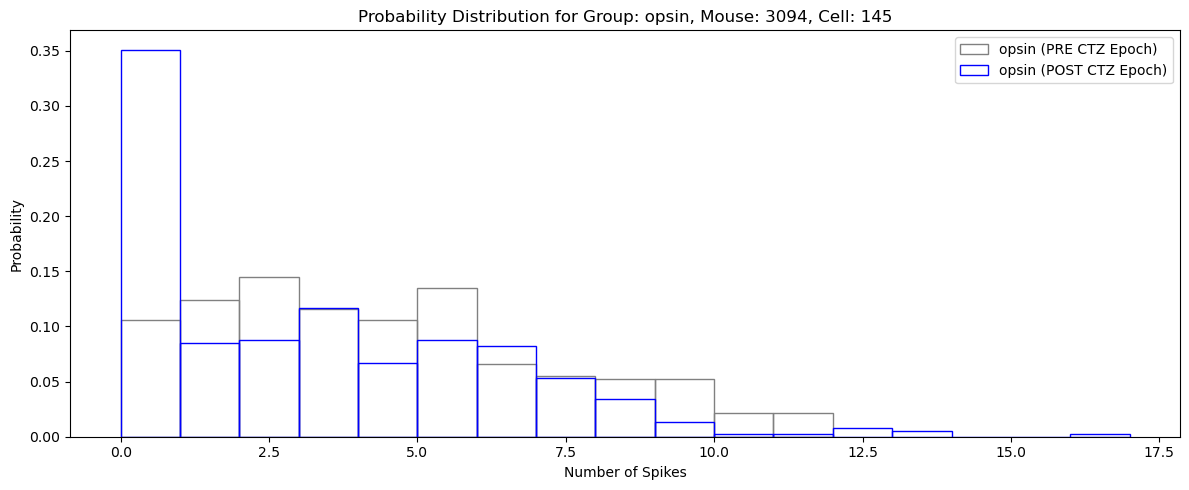

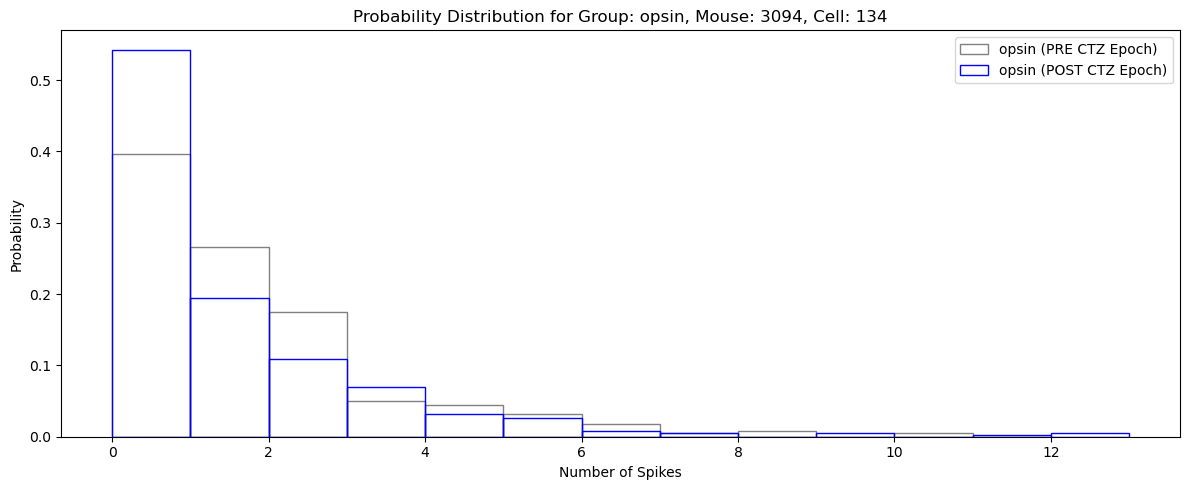

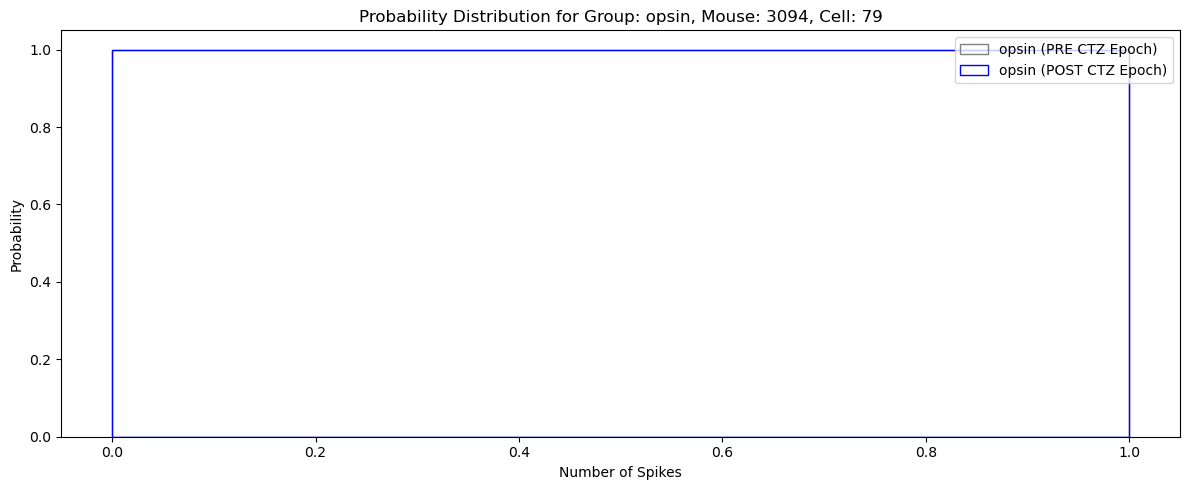

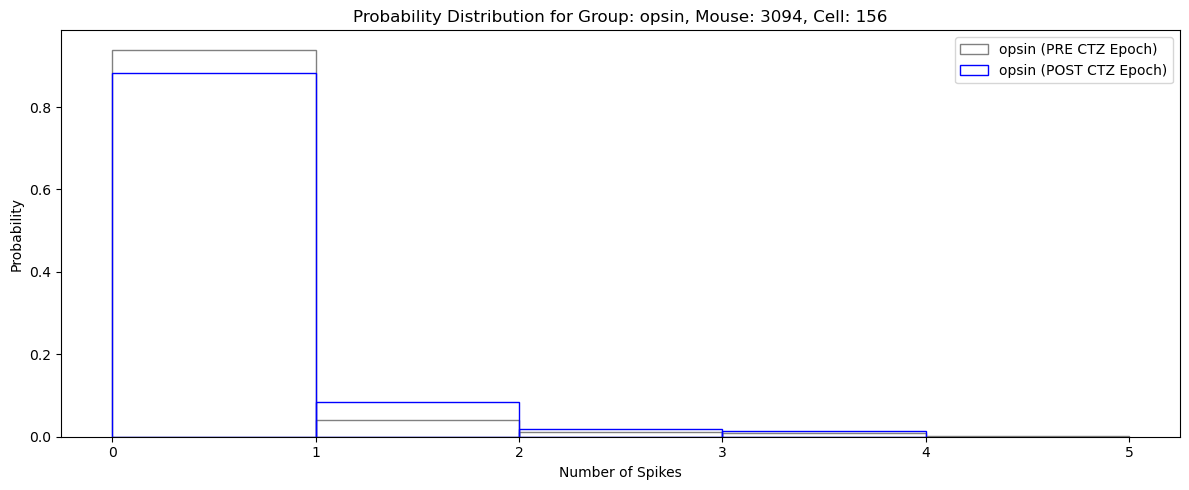

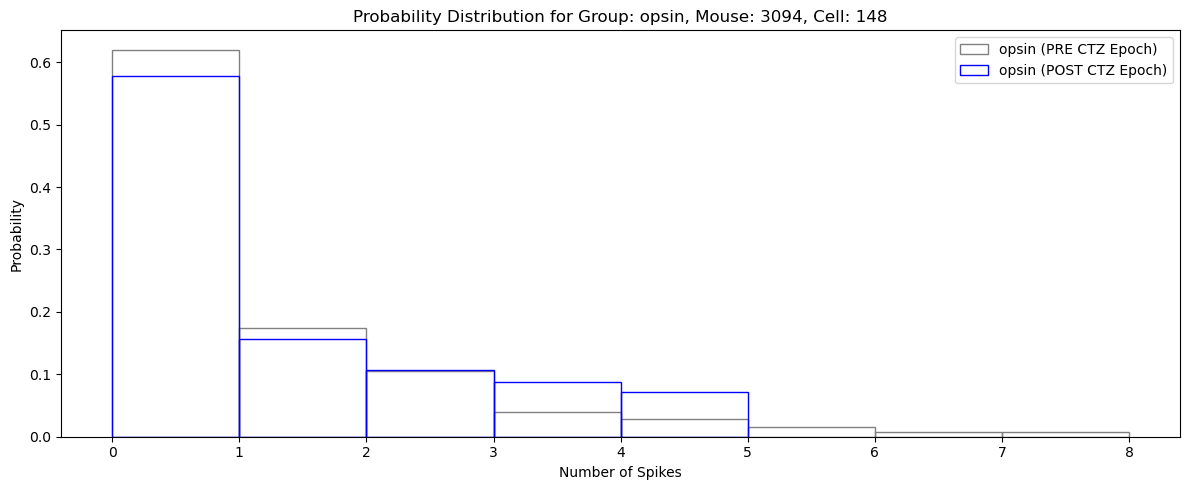

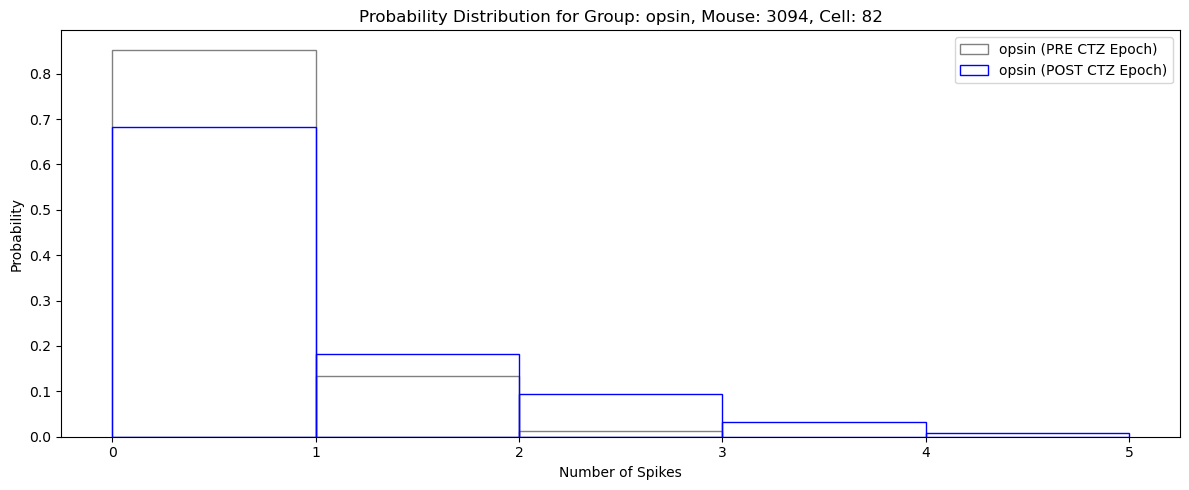

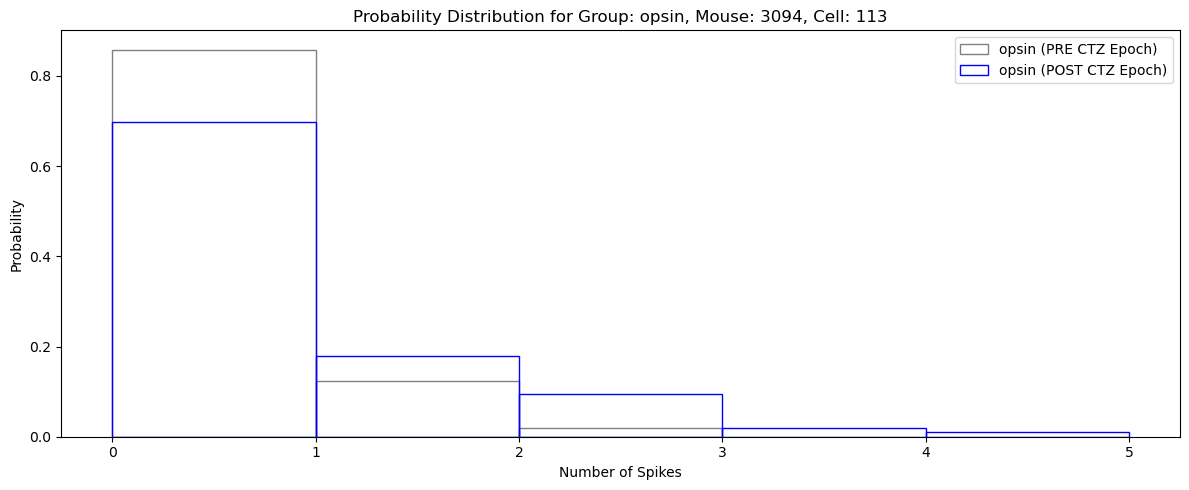

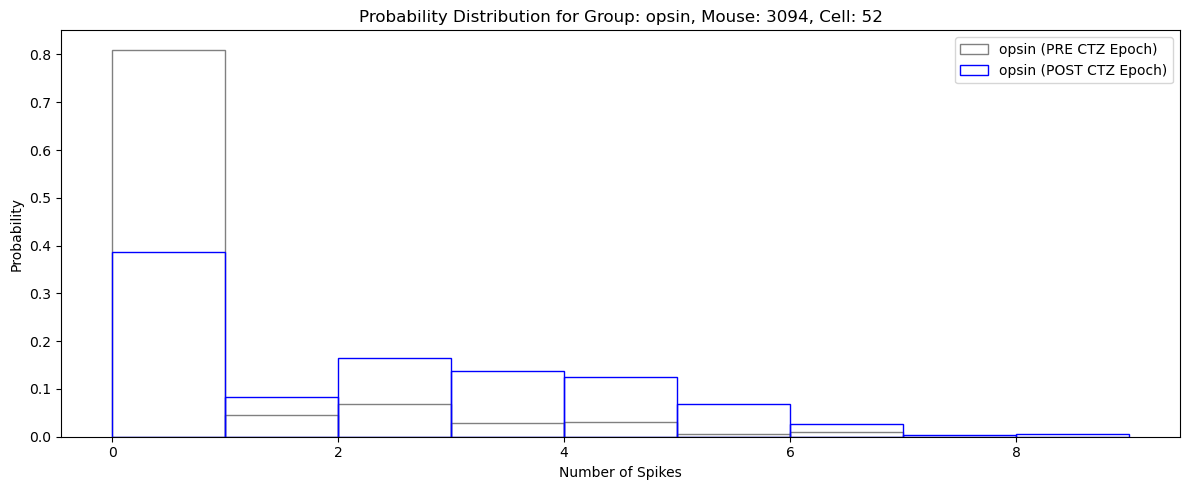

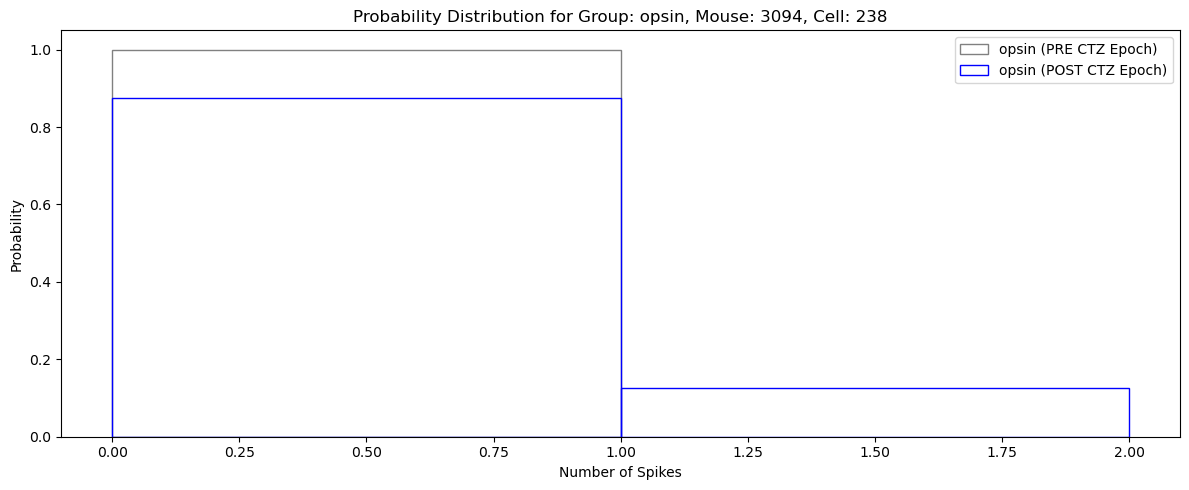

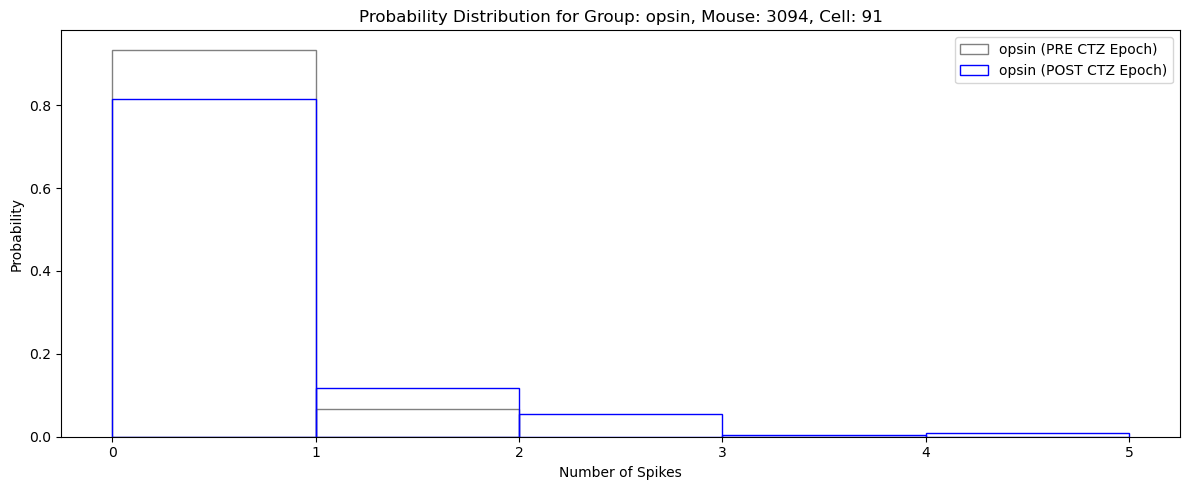

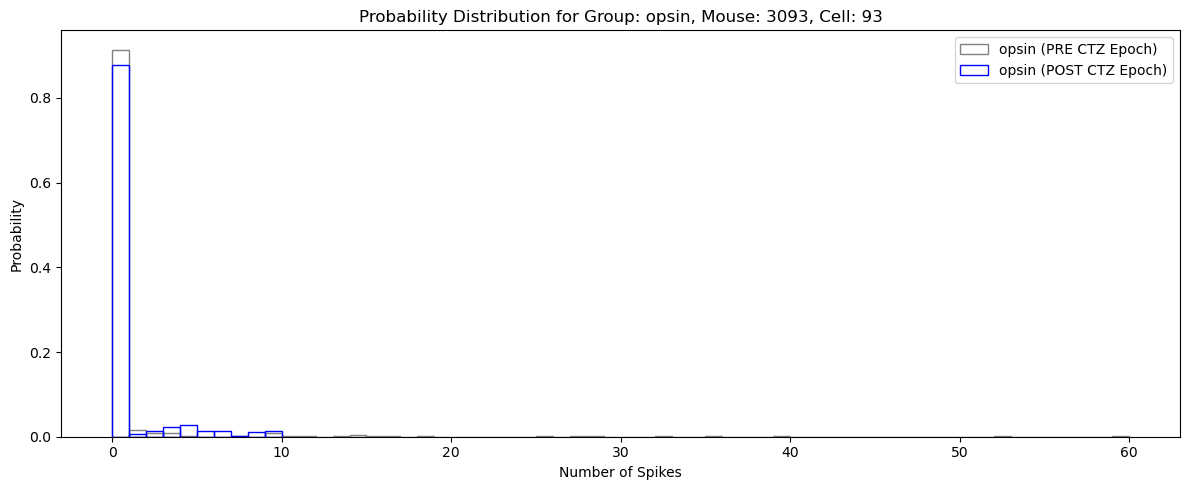

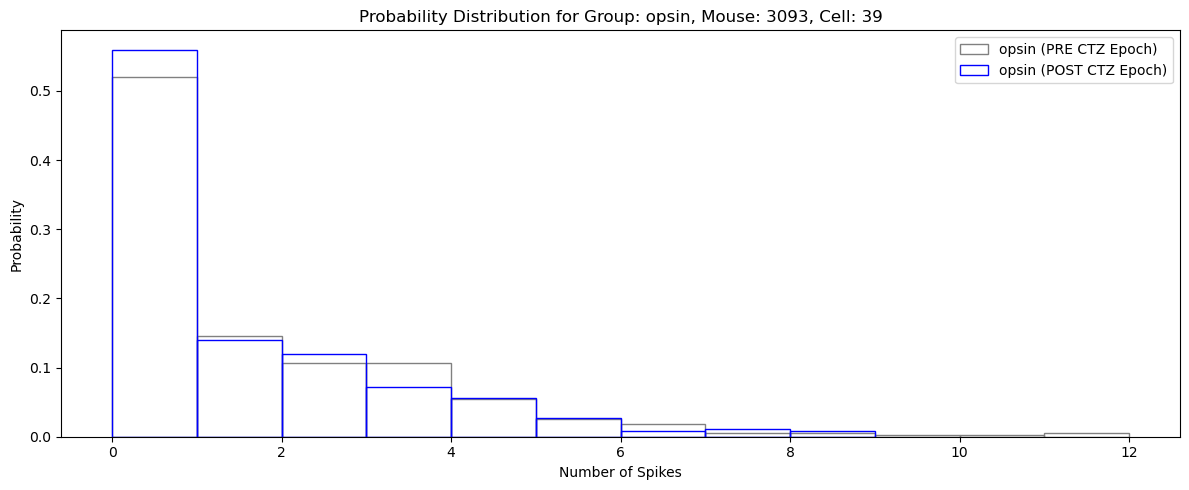

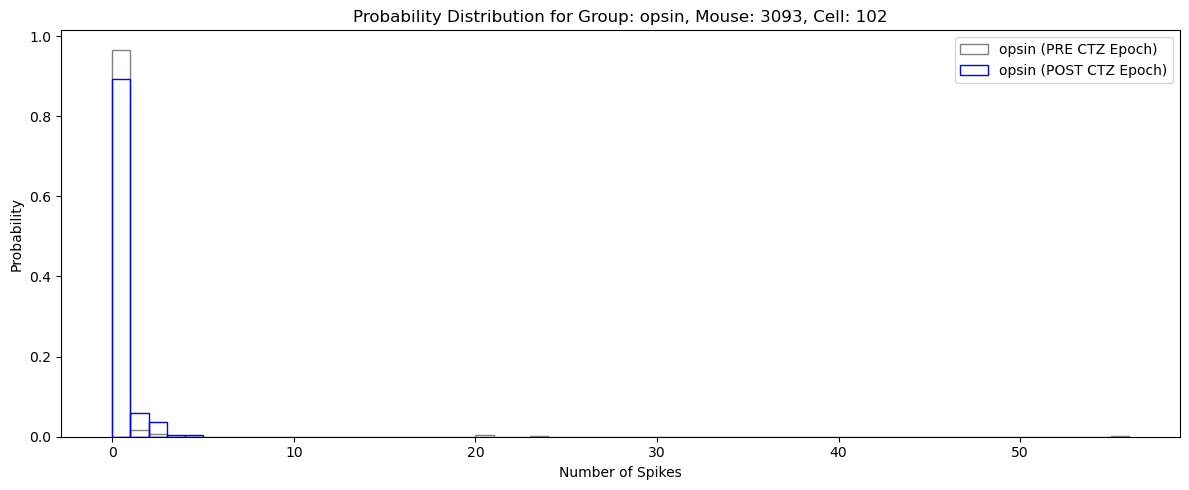

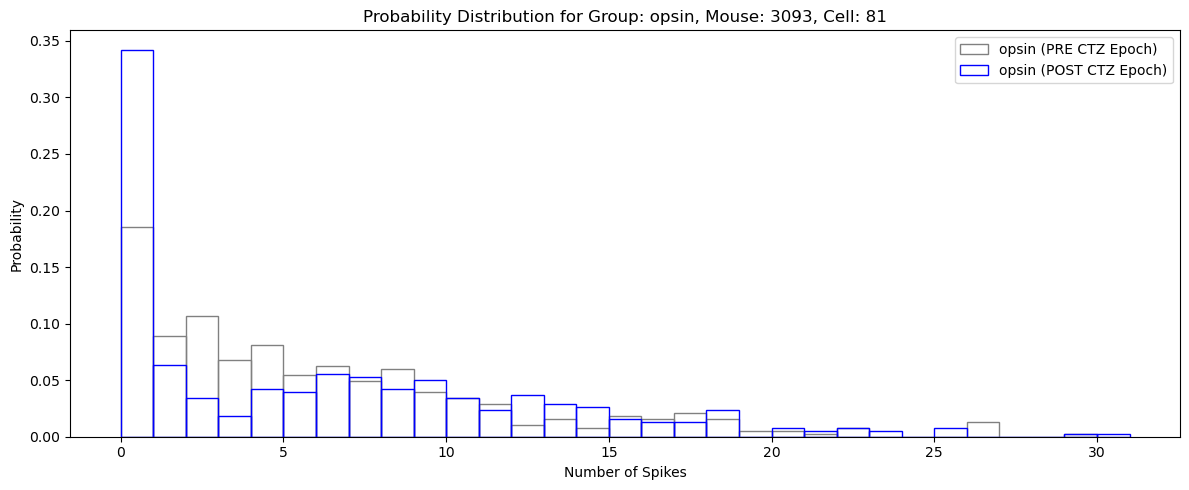

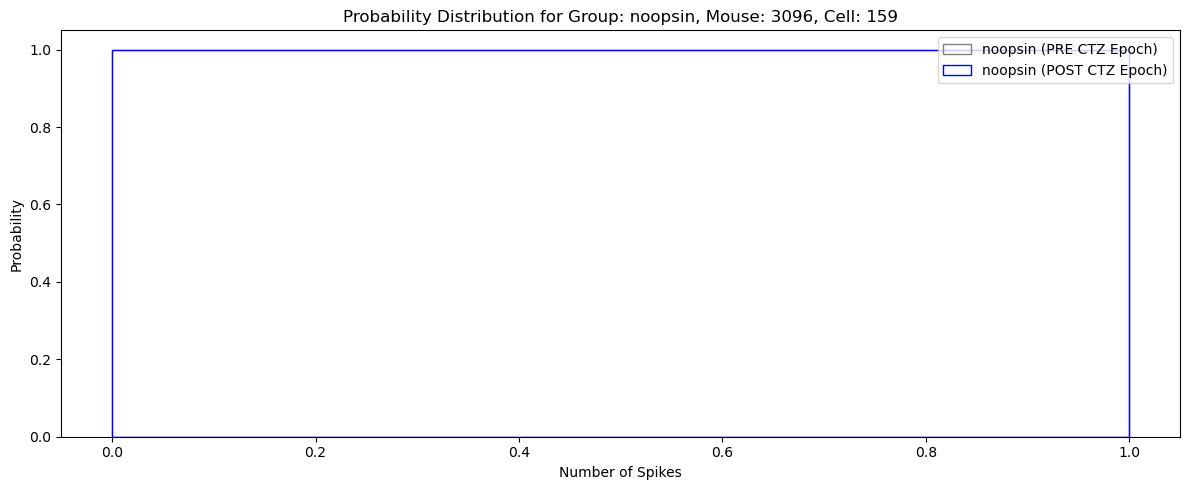

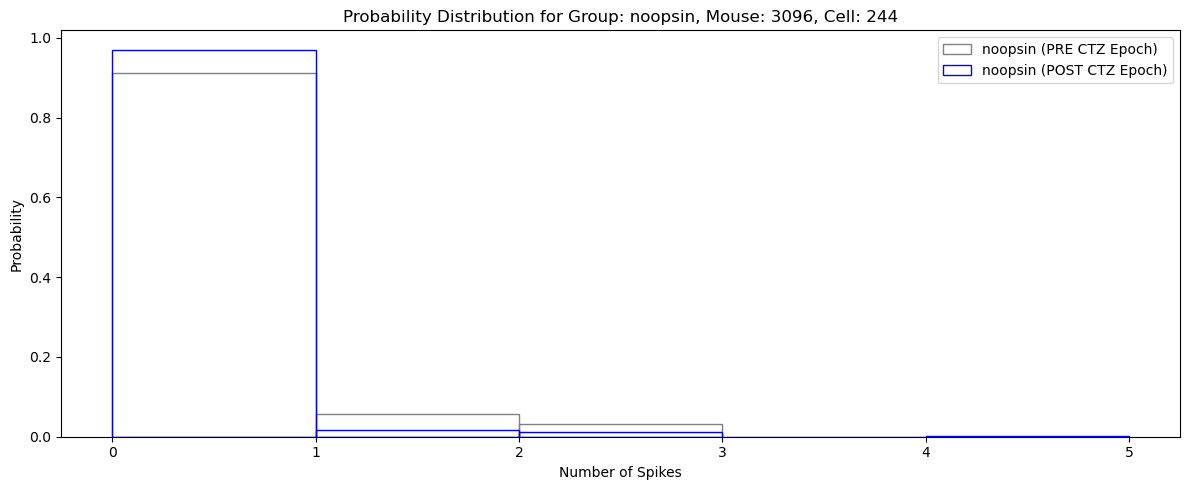

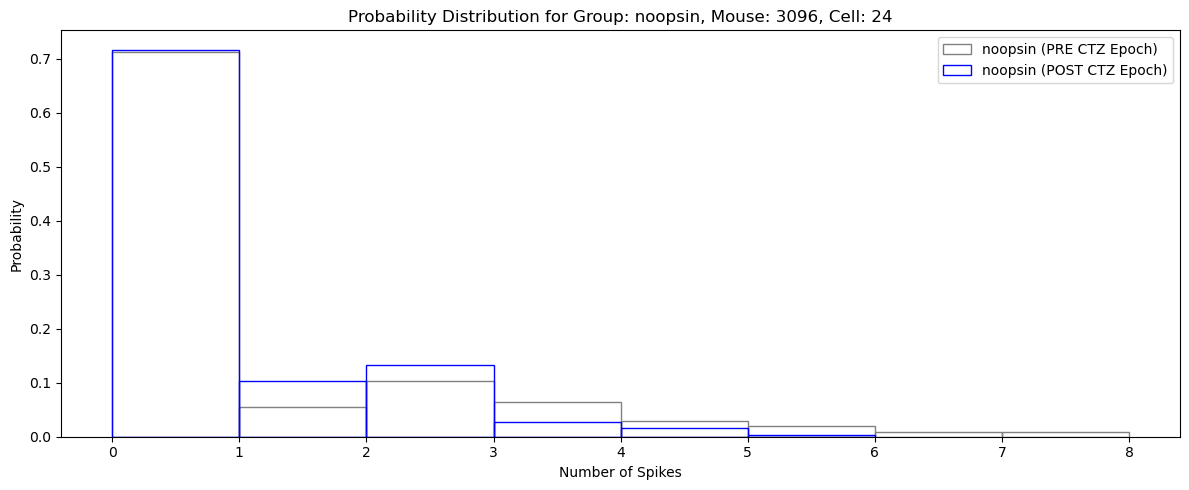

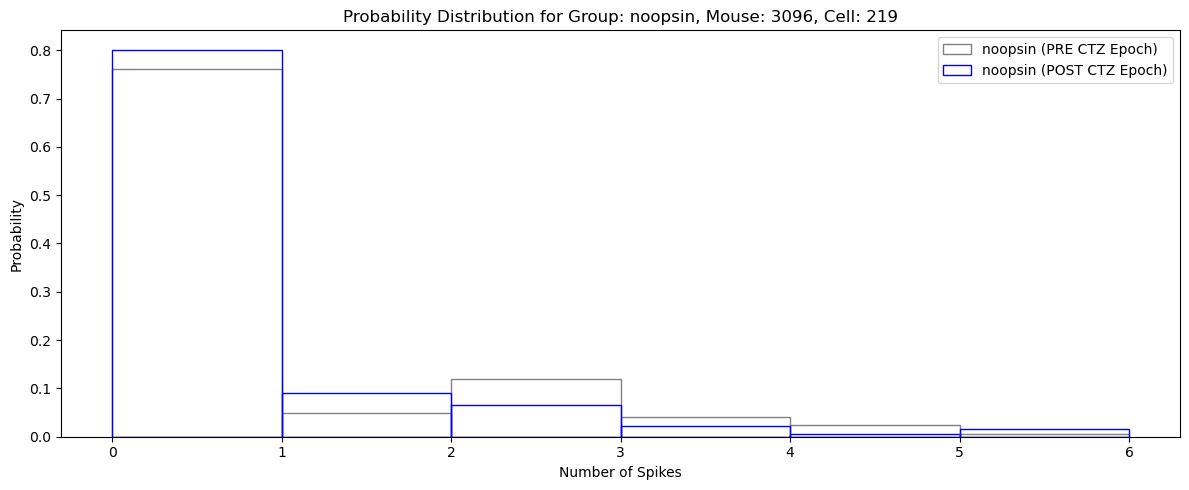

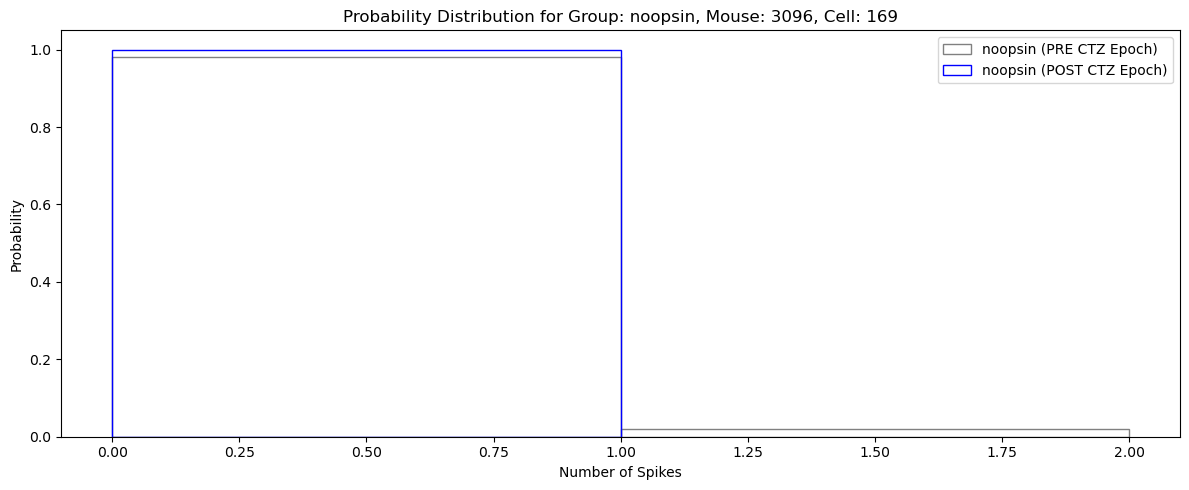

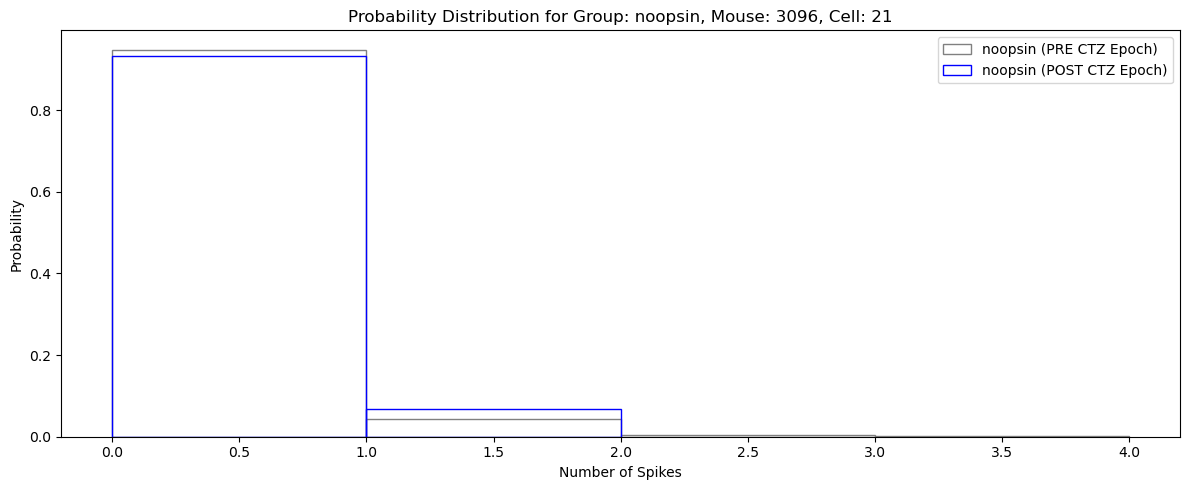

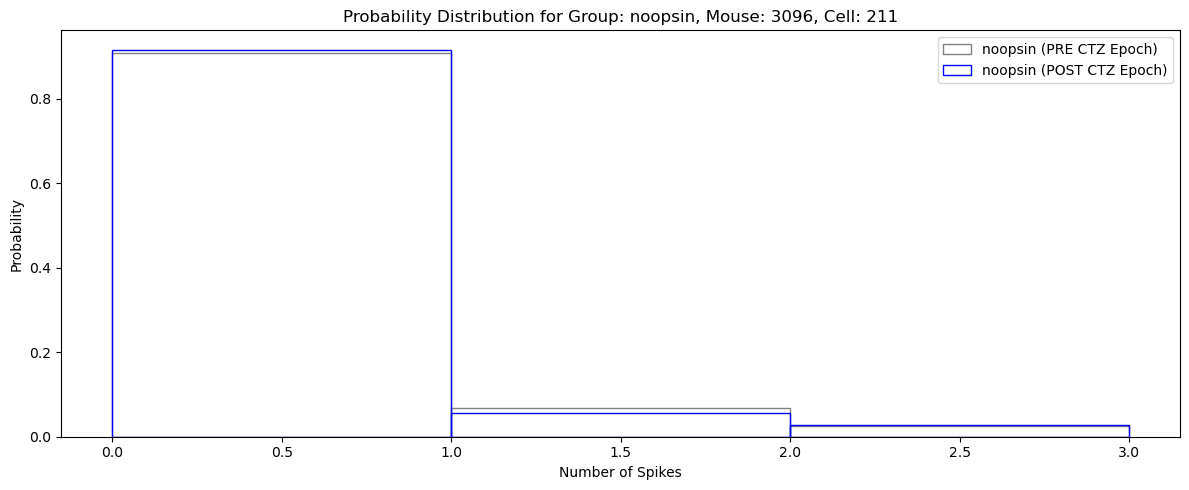

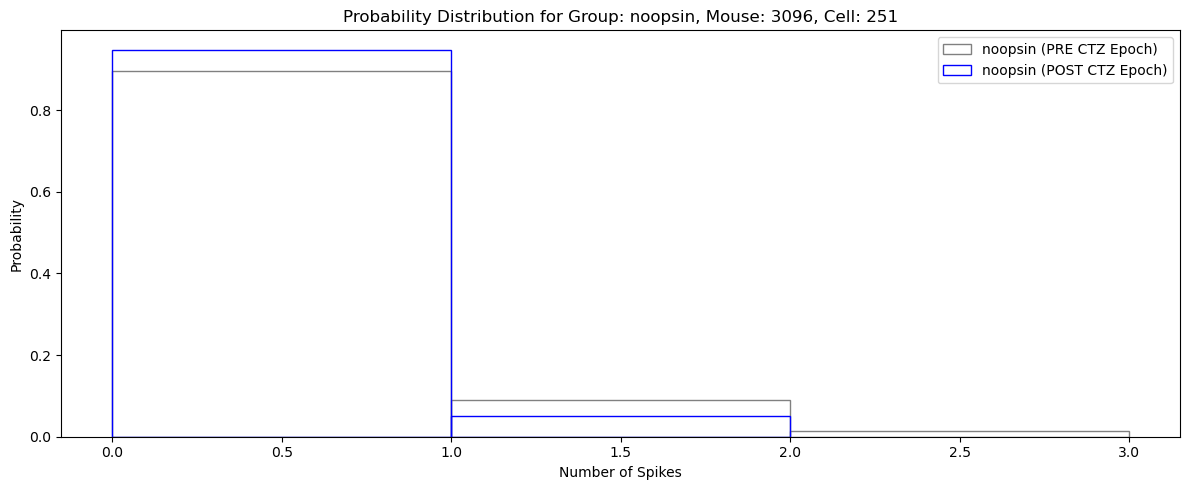

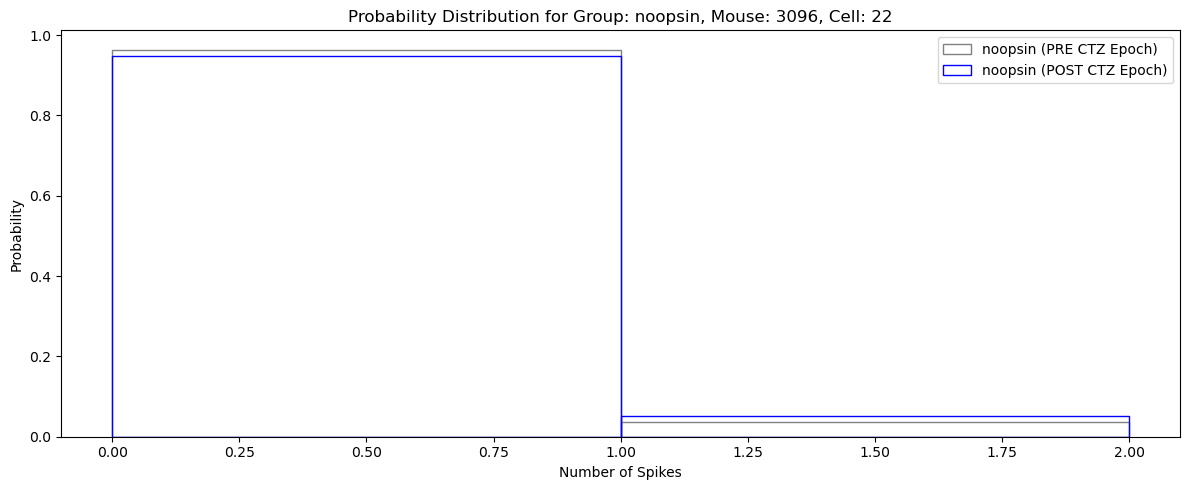

In [18]:
from collections import defaultdict
import os
import numpy as np
import matplotlib.pyplot as plt

def generate_cell_probability_histograms(directory, yaxis_cutoff=None, bin_size=None, time_window=(0, 500), exclude_zero_spikes=False):
    spike_counts_dict = {}
    window_start, window_end = time_window

    # Iterate through all .npy files in the specified directory
    for file_name in os.listdir(directory):
        if file_name.endswith("_combinedmatrix.npy"):
            parts = file_name.split("_")
            group_id = parts[0]  # "opsin" or "noopsin"
            mouse_id = parts[1]
            cell_id = parts[2]
            ctz_condition = parts[3]
            file_path = os.path.join(directory, file_name)
            matrix = np.load(file_path)
            custom_window = matrix[:, window_start:window_end]
            spike_counts = custom_window.sum(axis=1).tolist()

            # Exclude the zero spike count if the user opts for it
            if exclude_zero_spikes:
                spike_counts = [count for count in spike_counts if count != 0]

            # Manually initialize the nested dictionaries
            if group_id not in spike_counts_dict:
                spike_counts_dict[group_id] = {}
            if mouse_id not in spike_counts_dict[group_id]:
                spike_counts_dict[group_id][mouse_id] = {}
            if cell_id not in spike_counts_dict[group_id][mouse_id]:
                spike_counts_dict[group_id][mouse_id][cell_id] = {}
            spike_counts_dict[group_id][mouse_id][cell_id][ctz_condition] = spike_counts


    def plot_histogram(ax, spike_counts, edge_color, label, bin_size):
        bins = np.arange(0, max(spike_counts) + 1, bin_size) if bin_size else 'auto'
        hist_counts, bin_edges = np.histogram(spike_counts, bins=bins)
        probabilities = hist_counts / hist_counts.sum()
        ax.bar(bin_edges[:-1], probabilities, width=bin_size if bin_size else 1, edgecolor=edge_color, facecolor='none', align='edge')
        ax.set_xlabel("Number of Spikes")
        ax.set_ylabel("Probability")
        if yaxis_cutoff:
            ax.set_ylim(0, yaxis_cutoff)

    # Iterate through the unique groups (opsin and noopsin), mouse IDs, and cell IDs
    for group_id, group_files in spike_counts_dict.items():
        for mouse_id, mouse_files in group_files.items():
            for cell_id, ctz_files in mouse_files.items():
                fig, ax = plt.subplots(figsize=(12, 5))
                plot_histogram(ax, ctz_files['pre'], 'grey', f"{group_id} (PRE CTZ Epoch)", bin_size)
                plot_histogram(ax, ctz_files['post'], 'blue', f"{group_id} (POST CTZ Epoch)", bin_size)
                ax.legend([f"{group_id} (PRE CTZ Epoch)", f"{group_id} (POST CTZ Epoch)"])
                plt.title(f"Probability Distribution for Group: {group_id}, Mouse: {mouse_id}, Cell: {cell_id}")
                plt.tight_layout()
                plt.show()
                
                
yaxis_cutoff = None  # Optional: Define the y-axis cut-off
bin_size = 1        # Optional: Define the bin size
time_window = (0, 500) # Optional: Define the time window


generate_cell_probability_histograms(input_directory, yaxis_cutoff, bin_size, time_window, exclude_zero_spikes=False)

generate_group_probability_histograms function:

Description
The generate_group_probability_histograms function generates overlaid histograms for the "opsin" and "noopsin" groups, showing the probability distribution of the number of spikes for PRE and POST CTZ epochs. The function performs the following steps:

Load Data: Reads the data from .npy files located in the specified directory.
Data Processing: Processes the data according to groups ("opsin" or "noopsin") and conditions (PRE and POST CTZ). It sums the spike counts within a specified time window for each trial.
Create Histograms: Computes histograms for the two groups and two CTZ conditions, showing the probability distribution of the number of spikes.
Plotting: Plots overlaid histograms with bars filled white and edges colored grey or blue.

Parameters
directory (str): The path to the directory containing the .npy files.
yaxis_cutoff (float, optional): A value to set the y-axis limit for better visualization. If not provided, the y-axis will autoscale.
bin_size (int, optional): The size of the bins in the histogram. If not provided, an automatic bin size is used.
time_window (tuple, optional): A tuple specifying the start and end of the time window (in milliseconds) within which to sum the spikes. Defaults to (0, 500).
exclude_zero_spikes (bool, optional): If set to True, the bin corresponding to 0 spikes will be excluded from the histogram. Defaults to False.

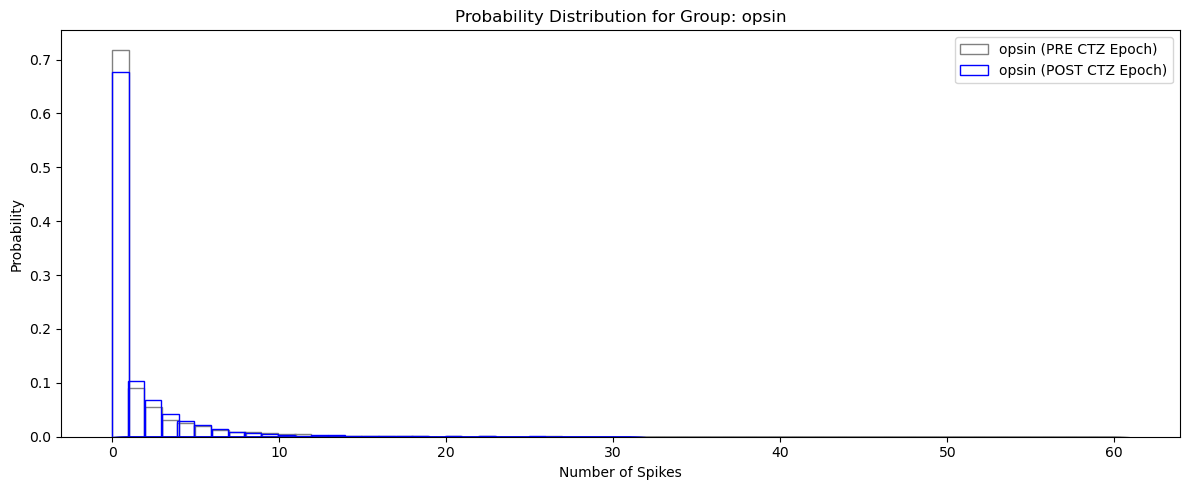

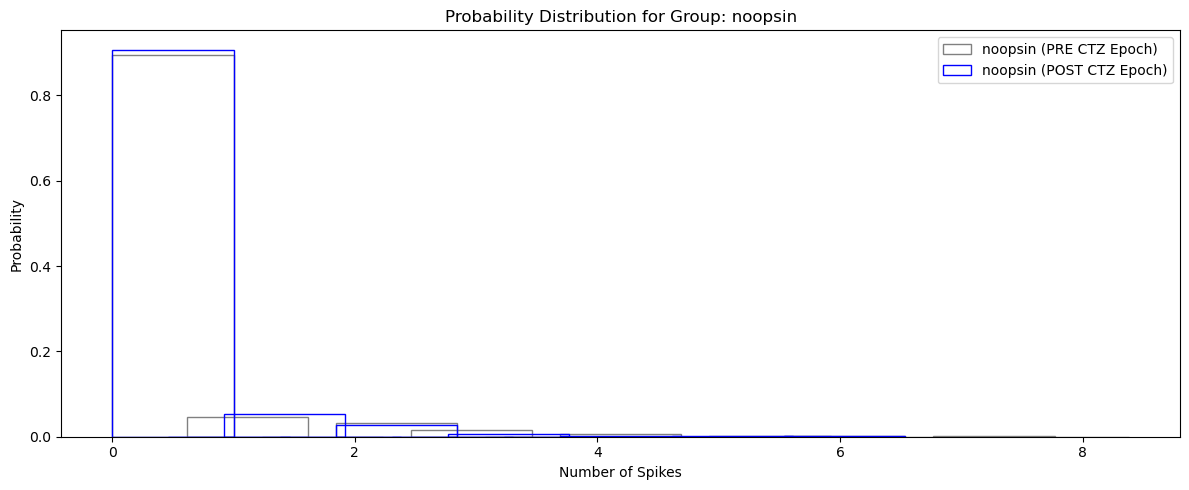

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt

def generate_group_probability_histograms(directory, yaxis_cutoff=None, bin_size=None, time_window=(0, 500), exclude_zero_spikes=False):
    spike_counts_dict = {'opsin': {'pre': [], 'post': []}, 'noopsin': {'pre': [], 'post': []}}
    window_start, window_end = time_window

    # Iterate through all .npy files in the specified directory
    for file_name in os.listdir(directory):
        if file_name.endswith("_combinedmatrix.npy"):
            parts = file_name.split("_")
            group_id = parts[0]  # "opsin" or "noopsin"
            ctz_condition = parts[3]
            file_path = os.path.join(directory, file_name)
            matrix = np.load(file_path)
            custom_window = matrix[:, window_start:window_end]
            spike_counts = custom_window.sum(axis=1).tolist()
            spike_counts_dict[group_id][ctz_condition].extend(spike_counts)

    def plot_histogram(ax, spike_counts, edge_color, label, bin_size):
        # Exclude the zero spike count if the user opts for it
        if exclude_zero_spikes:
            spike_counts = [count for count in spike_counts if count != 0]

        bins = np.arange(0, max(spike_counts) + 1, bin_size) if bin_size else 'auto'
        hist_counts, bin_edges = np.histogram(spike_counts, bins=bins)
        probabilities = hist_counts / hist_counts.sum()
        ax.bar(bin_edges[:-1], probabilities, width=bin_size if bin_size else 1, edgecolor=edge_color, facecolor='none', align='edge')
        ax.set_xlabel("Number of Spikes")
        ax.set_ylabel("Probability")
        if yaxis_cutoff:
            ax.set_ylim(0, yaxis_cutoff)

    for group_id, ctz_files in spike_counts_dict.items():
        fig, ax = plt.subplots(figsize=(12, 5))
        plot_histogram(ax, ctz_files['pre'], 'grey', f"{group_id} (PRE CTZ Epoch)", bin_size)
        plot_histogram(ax, ctz_files['post'], 'blue', f"{group_id} (POST CTZ Epoch)", bin_size)
        ax.legend([f"{group_id} (PRE CTZ Epoch)", f"{group_id} (POST CTZ Epoch)"])
        plt.title(f"Probability Distribution for Group: {group_id}")
        plt.tight_layout()
        plt.show()

yaxis_cutoff = None  # Optional: Define the y-axis cut-off
bin_size = None        # Optional: Define the bin size
time_window = (0, 500) # Optional: Define the time window

generate_group_probability_histograms(input_directory, yaxis_cutoff, bin_size, time_window, exclude_zero_spikes=False)


generate_group_probability_histograms Function

Description
The generate_group_probability_histograms function generates histograms displaying the probability distribution of the number of spikes for both the "opsin" and "noopsin" groups, in both PRE and POST CTZ epochs. The function allows two different layouts: the original overlay layout and a 2x1 layout.

Original Overlay Layout: Both PRE and POST CTZ epochs are plotted on the same graph, with different colors for each epoch.
2x1 Layout: Two separate subplots are created, with the PRE CTZ epoch on the left and the POST CTZ epoch on the right.

Parameters
directory (str): The path to the directory containing the .npy files.
yaxis_cutoff (float, optional): A value to set the y-axis limit for better visualization. If not provided, the y-axis will autoscale.
bin_size (int, optional): The size of the bins in the histogram. If not provided, an automatic bin size is used.
time_window (tuple, optional): A tuple specifying the start and end of the time window (in milliseconds) within which to sum the spikes. Defaults to (0, 500).
exclude_zero_spikes (bool, optional): If set to True, the bin corresponding to 0 spikes will be excluded from the histogram. Defaults to False.
layout_2x1 (bool, optional): If set to True, the 2x1 layout is used. If set to False, the original overlay layout is used. Defaults to False.

Functionality
Load Data: Reads the data from .npy files located in the specified directory.
Data Processing: Processes the data according to groups ("opsin" or "noopsin") and conditions (PRE and POST CTZ). It sums the spike counts within the specified time window for each trial.
Create Histograms: Computes histograms for the two groups and two CTZ conditions, showing the probability distribution of the number of spikes.

Plotting:
In the original overlay layout, the histograms for PRE and POST CTZ epochs are overlaid on the same plot for each group.
In the 2x1 layout, two subplots are created for each group, showing the PRE CTZ epoch on the left and the POST CTZ epoch on the right.

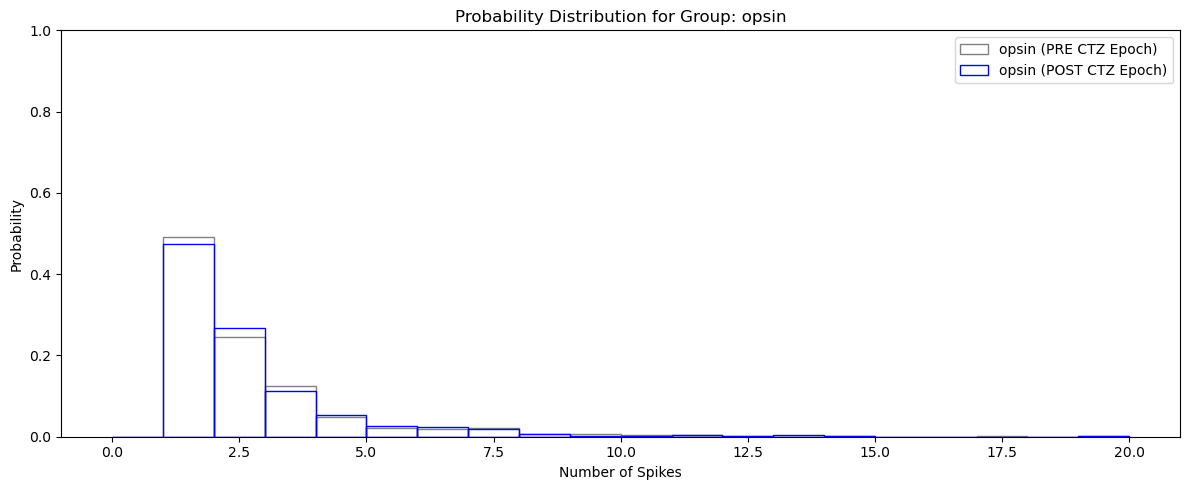

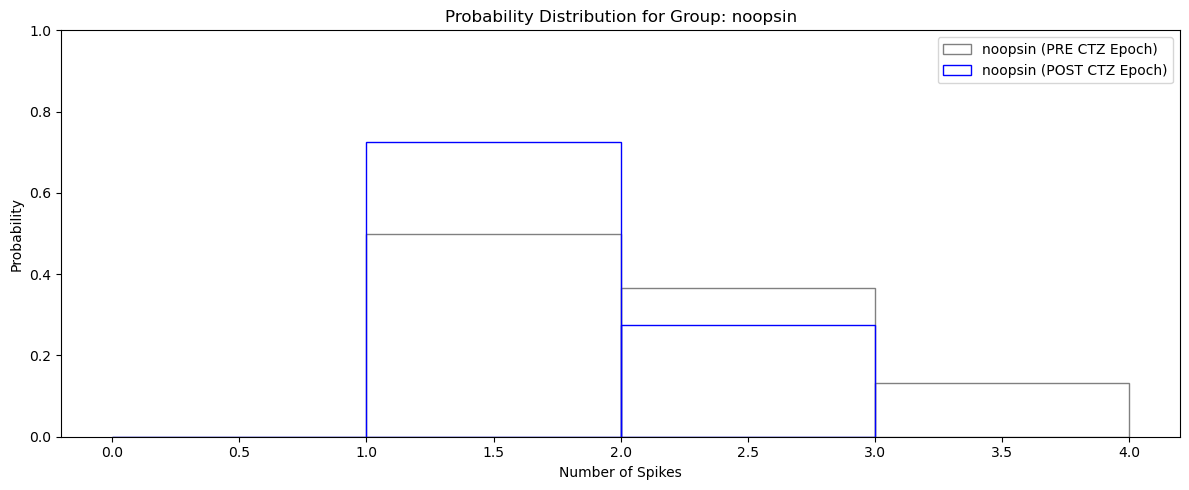

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def generate_group_probability_histograms(directory, yaxis_cutoff=None, bin_size=None, time_window=(0, 500), exclude_zero_spikes=False, layout_2x1=False):
    spike_counts_dict = {'opsin': {'pre': [], 'post': []}, 'noopsin': {'pre': [], 'post': []}}
    window_start, window_end = time_window

    # Iterate through all .npy files in the specified directory
    for file_name in os.listdir(directory):
        if file_name.endswith("_combinedmatrix.npy"):
            parts = file_name.split("_")
            group_id = parts[0]  # "opsin" or "noopsin"
            ctz_condition = parts[3]
            file_path = os.path.join(directory, file_name)
            matrix = np.load(file_path)
            custom_window = matrix[:, window_start:window_end]
            spike_counts = custom_window.sum(axis=1).tolist()
            spike_counts_dict[group_id][ctz_condition].extend(spike_counts)

    def plot_histogram(ax, spike_counts, edge_color, label, bin_size):
        # Exclude the zero spike count if the user opts for it
        if exclude_zero_spikes:
            spike_counts = [count for count in spike_counts if count != 0]

        bins = np.arange(0, max(spike_counts) + 1, bin_size) if bin_size else 'auto'
        hist_counts, bin_edges = np.histogram(spike_counts, bins=bins)
        probabilities = hist_counts / hist_counts.sum()
        ax.bar(bin_edges[:-1], probabilities, width=bin_size if bin_size else 1, edgecolor=edge_color, facecolor='none', align='edge')
        ax.set_xlabel("Number of Spikes")
        ax.set_ylabel("Probability")
        if yaxis_cutoff:
            ax.set_ylim(0, yaxis_cutoff)

    for group_id, ctz_files in spike_counts_dict.items():
        if layout_2x1:
            # 2x1 layout
            fig, axes = plt.subplots(1, 2, figsize=(15, 5))
            plot_histogram(axes[0], ctz_files['pre'], 'grey', f"{group_id} (PRE CTZ Epoch)", bin_size)
            plot_histogram(axes[1], ctz_files['post'], 'blue', f"{group_id} (POST CTZ Epoch)", bin_size)
            fig.suptitle(f"Probability Distribution for Group: {group_id}")
        else:
            # Original overlay layout
            fig, ax = plt.subplots(figsize=(12, 5))
            plot_histogram(ax, ctz_files['pre'], 'grey', f"{group_id} (PRE CTZ Epoch)", bin_size)
            plot_histogram(ax, ctz_files['post'], 'blue', f"{group_id} (POST CTZ Epoch)", bin_size)
            ax.legend([f"{group_id} (PRE CTZ Epoch)", f"{group_id} (POST CTZ Epoch)"])
            plt.title(f"Probability Distribution for Group: {group_id}")
        plt.tight_layout()
        plt.show()





# Optional parameters
yaxis_cutoff = 1
bin_size = 1
time_window = (350, 500)
exclude_zero_spikes = True
top_percentile = 25
bottom_percentile = 50

# Call the function
#generate_cell_probability_histograms_percentiles(input_directory, yaxis_cutoff, bin_size, time_window, exclude_zero_spikes, top_percentile, bottom_percentile)
generate_group_probability_histograms(input_directory, yaxis_cutoff, bin_size, time_window, exclude_zero_spikes, layout_2x1=False)



In [14]:
def separate_trials_by_state(directory, top_percentile=10, bottom_percentile=10, time_window=(0, 500)):
    separated_trials_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list)))))
    window_start, window_end = time_window

    # Iterate through all .npy files in the specified directory
    for file_name in os.listdir(directory):
        if file_name.endswith("_combinedmatrix.npy"):
            parts = file_name.split("_")
            group_id, mouse_id, cell_id, ctz_condition = parts[:4]
            file_path = os.path.join(directory, file_name)
            matrix = np.load(file_path)
            custom_window = matrix[:, window_start:window_end]
            spike_counts = custom_window.sum(axis=1).tolist()

            # Compute thresholds for top and bottom percentiles
            top_threshold = np.percentile(spike_counts, 100 - top_percentile)
            bottom_threshold = np.percentile(spike_counts, bottom_percentile)

            # Separate the trials into Up, Down, and Discarded states
            for trial_index, spike_count in enumerate(spike_counts):
                trial = matrix[trial_index, :]
                if spike_count >= top_threshold:
                    state = "Up"
                elif spike_count <= bottom_threshold:
                    state = "Down"
                else:
                    state = "Discarded"

                separated_trials_dict[group_id][mouse_id][cell_id][ctz_condition][state].append(trial)

    return separated_trials_dict

directory = "/path/to/your/directory"
separated_trials = separate_trials_by_state(input_directory, top_percentile=10, bottom_percentile=10)

# You can now access the separated trials using the keys: group_id, mouse_id, cell_id, ctz_condition (either 'pre' or 'post'), and state ('Up', 'Down', 'Discarded').


Description
This function separates and plots the neural trials based on the given directory containing the spike data. It classifies trials into "Upstates", "Downstates", or "Discarded" based on the spike count percentiles. It also allows visualization of the trials with the option to hide discarded ones.

Parameters

directory (str): Path to the directory containing .npy files with neural spike data.
top_percentile (int, optional): The percentile for defining the threshold for "Upstates". Default is 10.
bottom_percentile (int, optional): The percentile for defining the threshold for "Downstates". Default is 10.
baseline_window (tuple, optional): The time window for calculating the baseline spike count (start, end). Default is (0, 500).
stimulation_window (tuple, optional): The time window for displaying the stimulation on the plot (start, end). Default is (500, 1000).
max_plots (int, optional): The maximum number of plots to generate. Default is 30.
show_discarded (bool, optional): If False, the discarded trials will not be plotted. Default is True.
smoothing_window: The size of the smoothing window applied to the data.

Detailed Description
Initialization: The function initializes dictionaries and variables for holding the data, thresholds, and counters.

File Reading: Iterates through files in the given directory and separates the file name into parts to identify the group, mouse, cell, and CTZ condition. It creates a mapping of cell data.

Data Processing: Iterates through the cell data, loads the matrix, and calculates the baseline spike counts. It further filters out zero spike counts and calculates the top and bottom thresholds for defining Upstates and Downstates.

Trial Classification: For each spike count, the trial is classified into one of the three states (Upstates, Downstates, or Discarded). If the spike count is zero, it is marked as Discarded.

Plotting: Plots the mean of the trials for each state, with the option to hide discarded trials. It also adds labels and legends to the plot.

Showing Plots: Displays the plots and increments the plot counter. It stops plotting once the maximum number of plots is reached.

Return Value: Returns a nested dictionary containing the classified states of the trials.

Return Value
states_dict (defaultdict): A nested dictionary containing the classified states (Upstates, Downstates, Discarded) of the trials for each group, mouse, cell, and CTZ condition.

This code can be used to process and visualize neural spike data, and the function provides flexibility in defining the criteria for classification and visualization.

Group: opsin, Mouse: 3094, Cell: 145
Pre CTZ files: 1, Post CTZ files: 1
Group: opsin, Mouse: 3094, Cell: 134
Pre CTZ files: 1, Post CTZ files: 1
Group: opsin, Mouse: 3094, Cell: 79
Pre CTZ files: 1, Post CTZ files: 1
Group: opsin, Mouse: 3094, Cell: 156
Pre CTZ files: 1, Post CTZ files: 1
Group: opsin, Mouse: 3094, Cell: 148
Pre CTZ files: 1, Post CTZ files: 1
Group: opsin, Mouse: 3094, Cell: 82
Pre CTZ files: 1, Post CTZ files: 1
Group: opsin, Mouse: 3094, Cell: 113
Pre CTZ files: 1, Post CTZ files: 1
Group: opsin, Mouse: 3094, Cell: 52
Pre CTZ files: 1, Post CTZ files: 1
Group: opsin, Mouse: 3094, Cell: 238
Pre CTZ files: 1, Post CTZ files: 1
Group: opsin, Mouse: 3094, Cell: 91
Pre CTZ files: 1, Post CTZ files: 1
Group: opsin, Mouse: 3093, Cell: 93
Pre CTZ files: 1, Post CTZ files: 1
Group: opsin, Mouse: 3093, Cell: 39
Pre CTZ files: 1, Post CTZ files: 1
Group: opsin, Mouse: 3093, Cell: 102
Pre CTZ files: 1, Post CTZ files: 1
Group: opsin, Mouse: 3093, Cell: 81
Pre CTZ files: 1, Pos

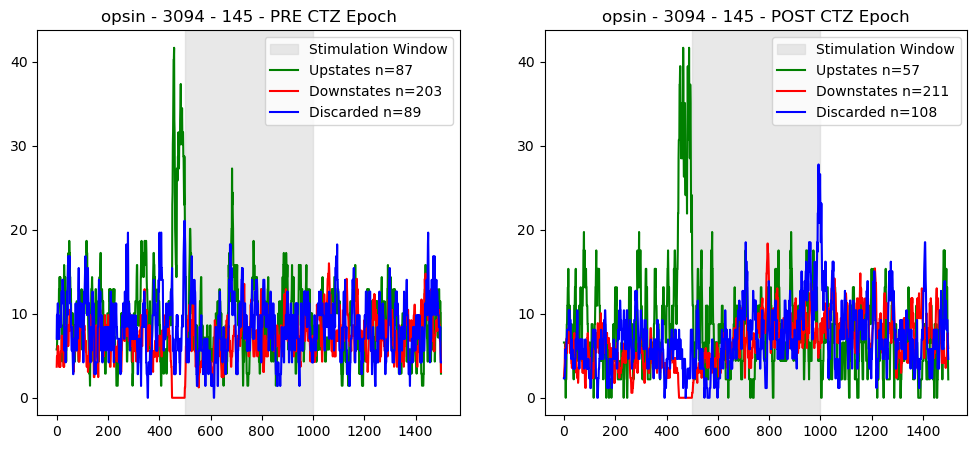

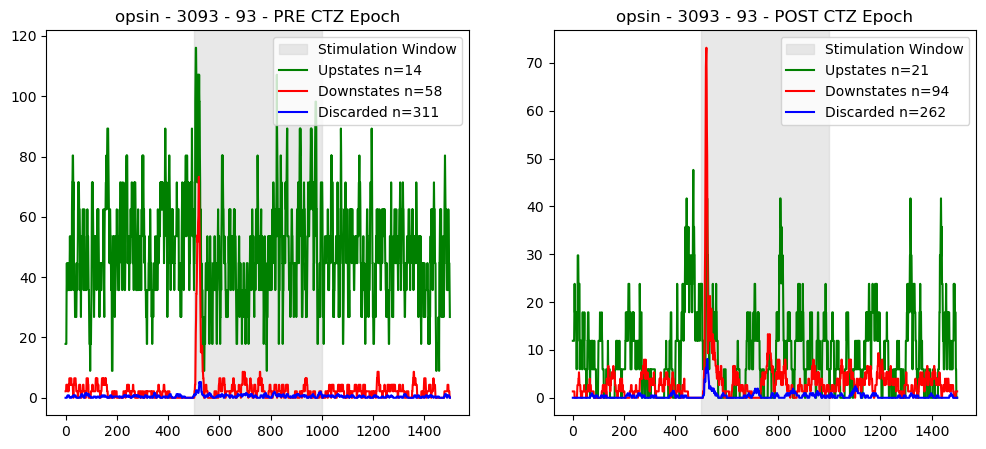

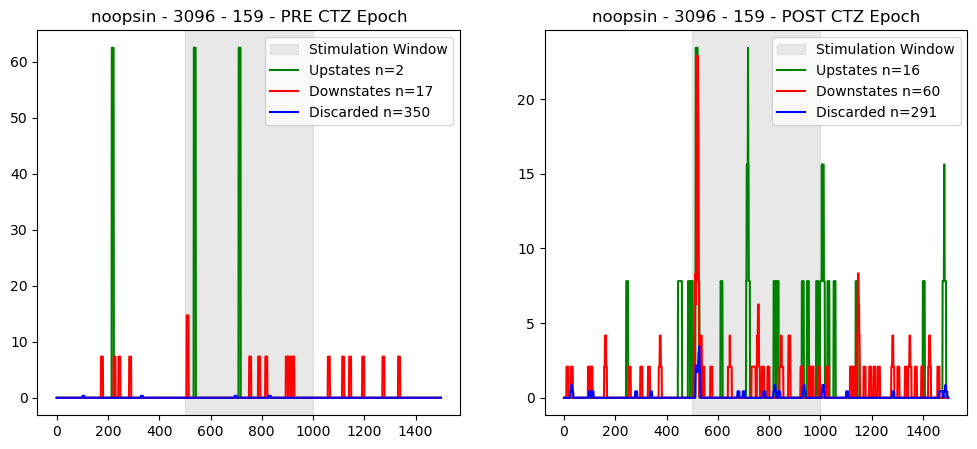

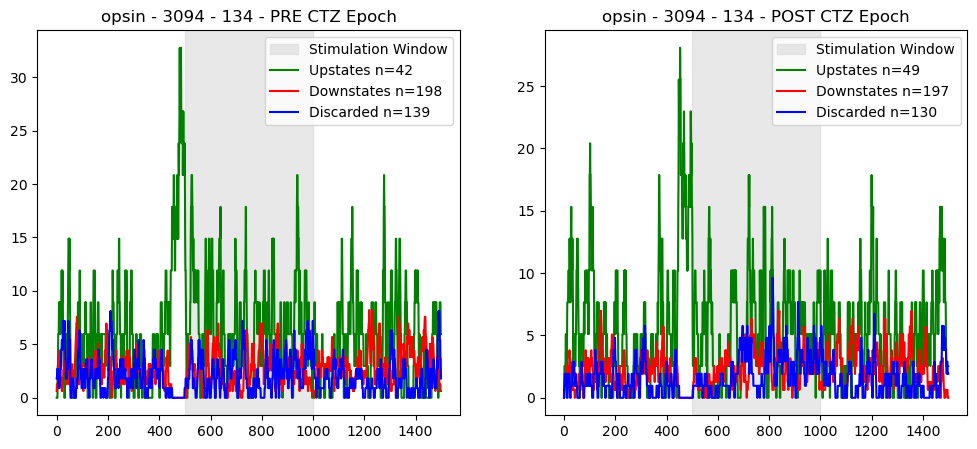

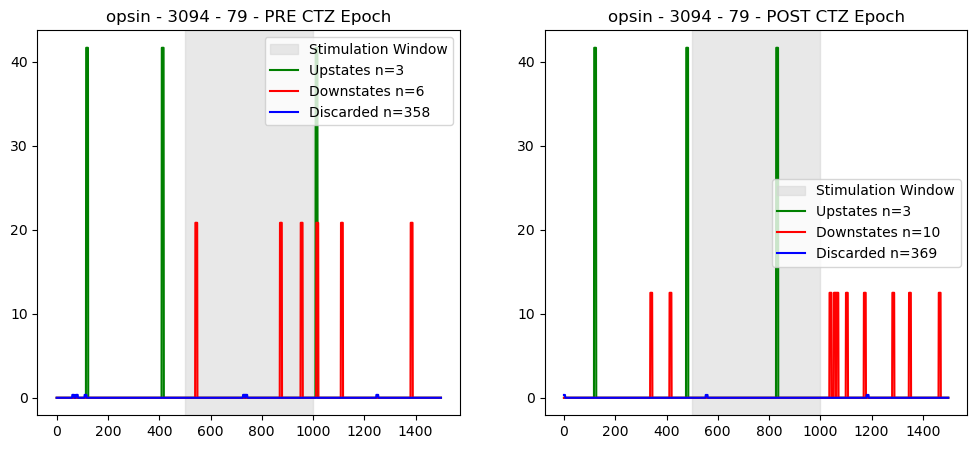

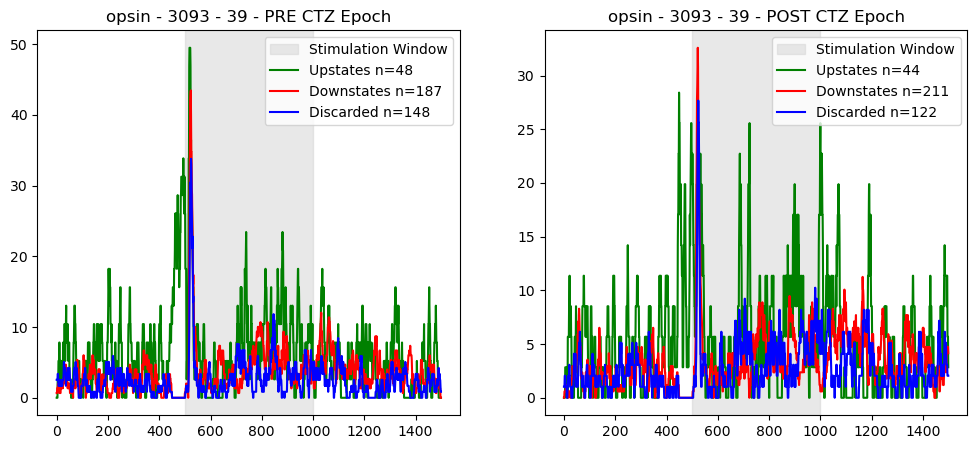

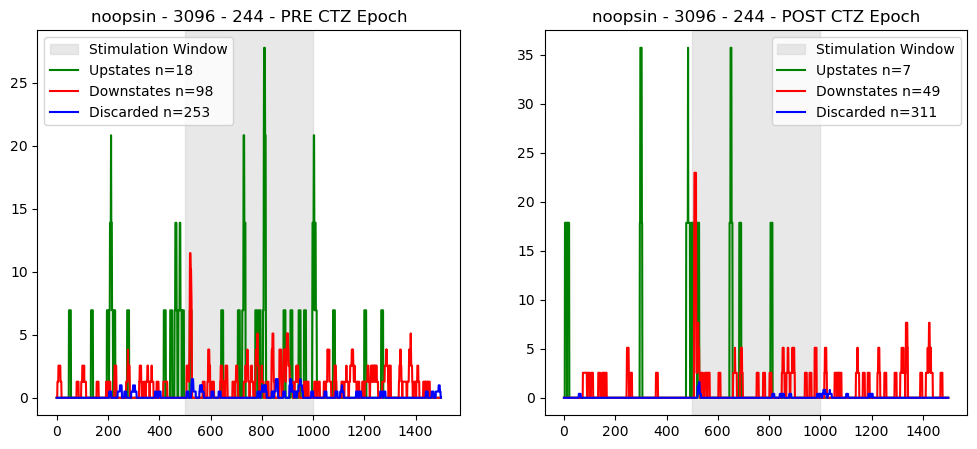

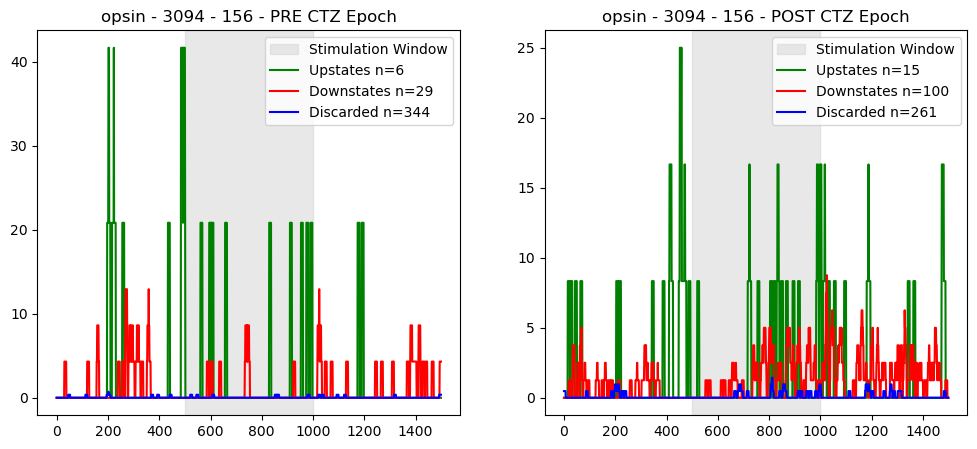

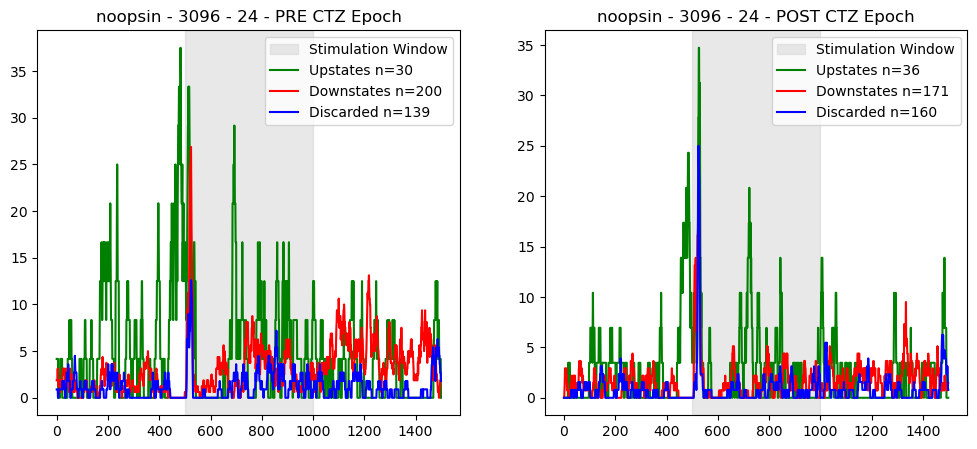

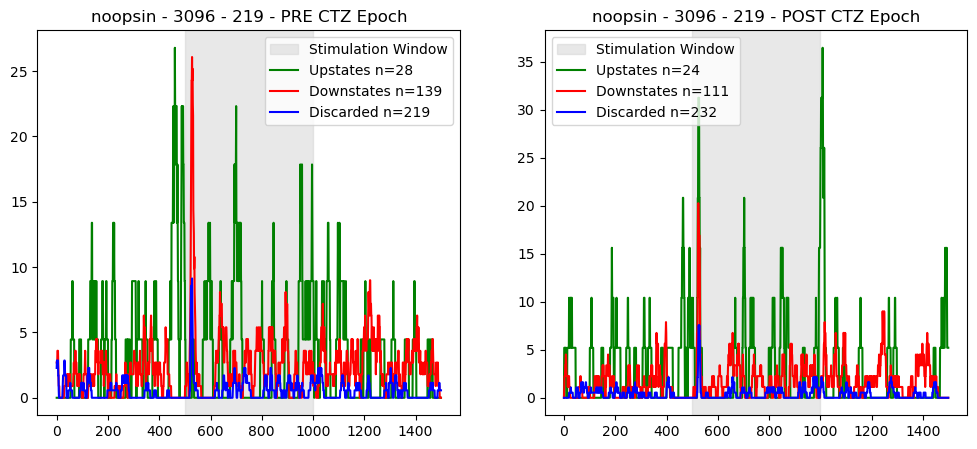

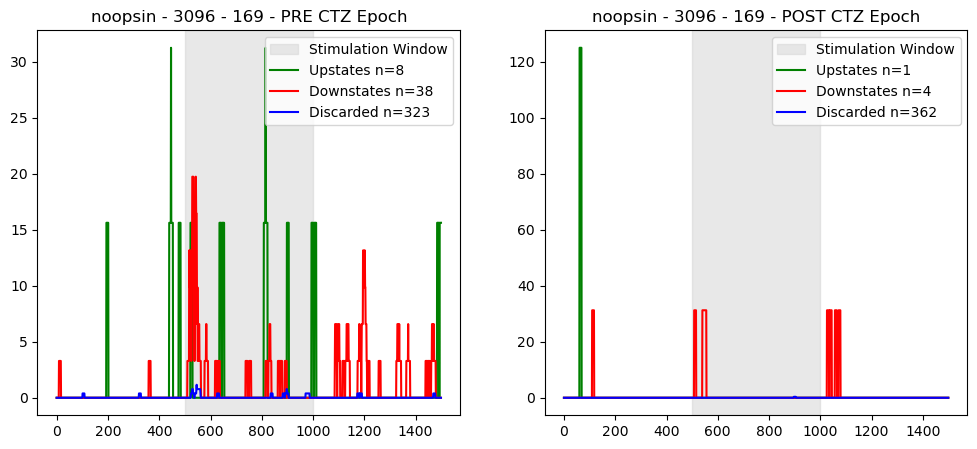

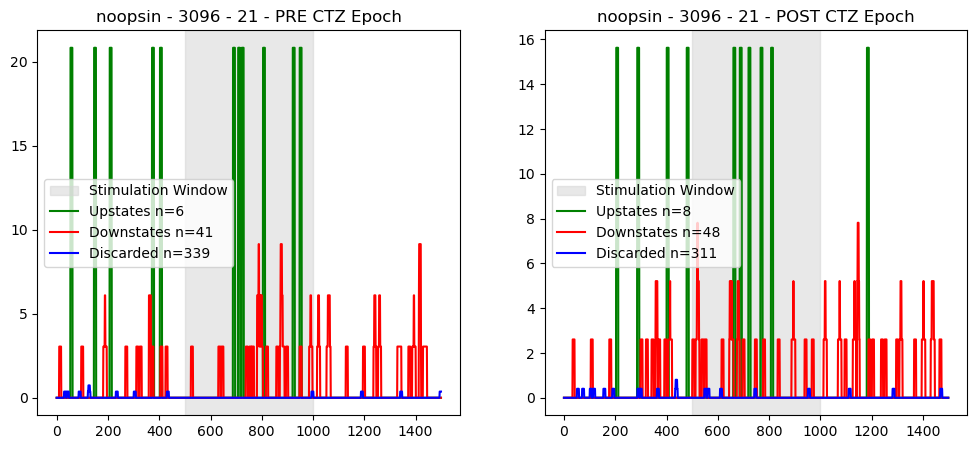

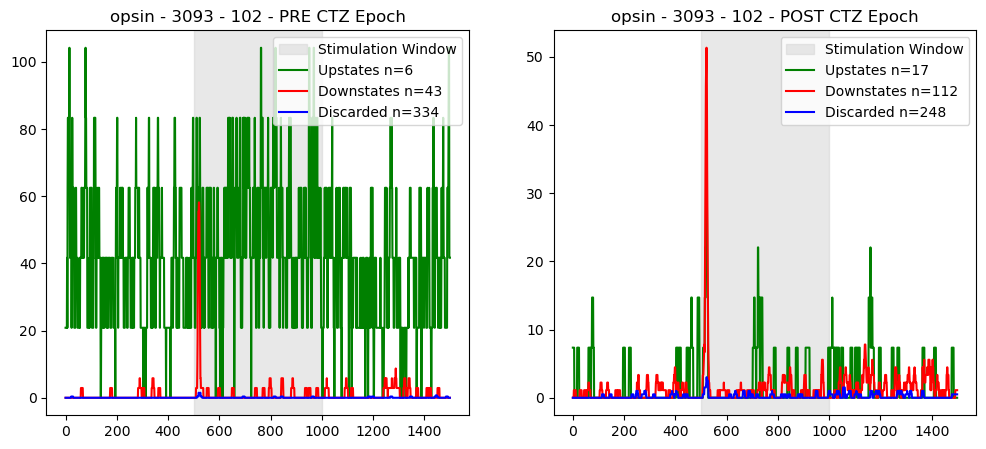

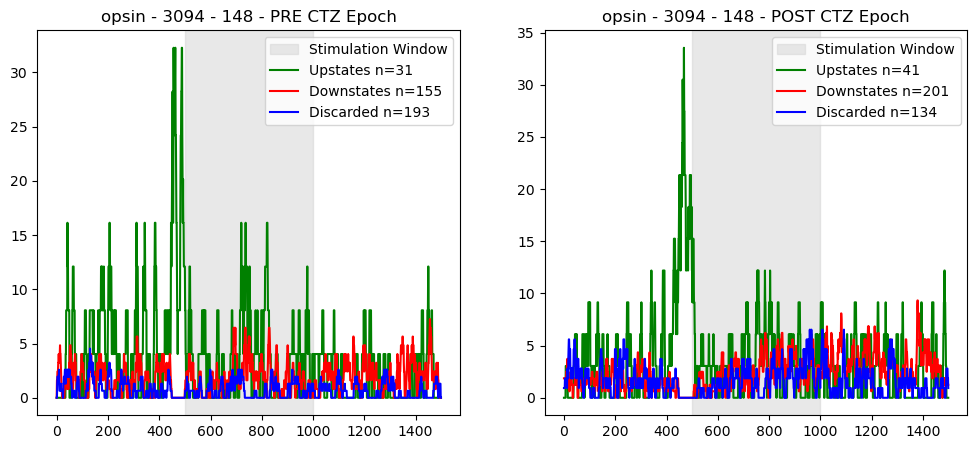

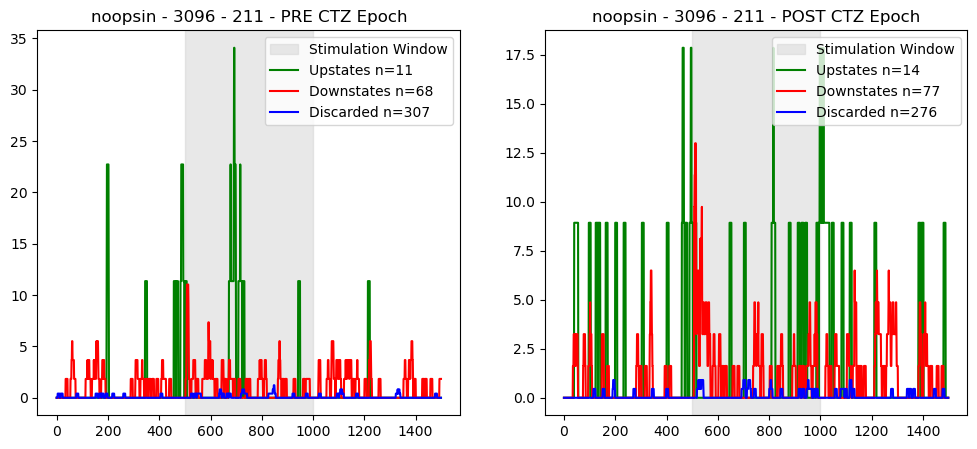

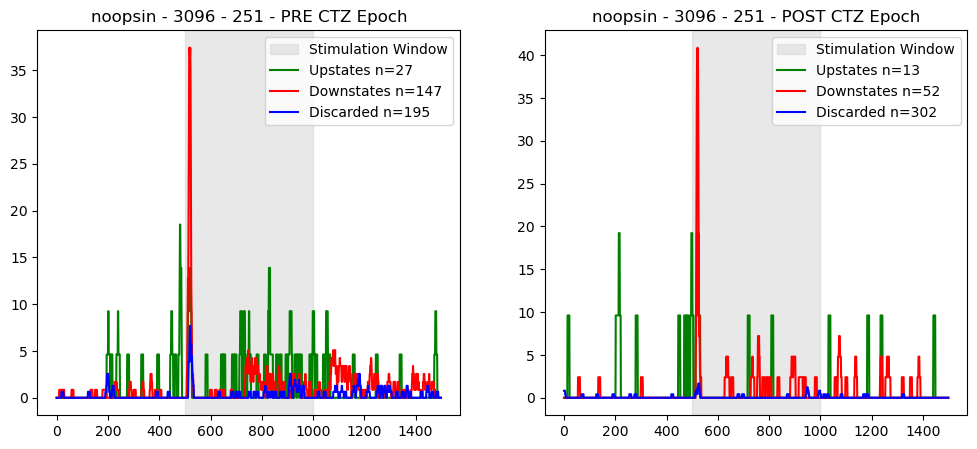

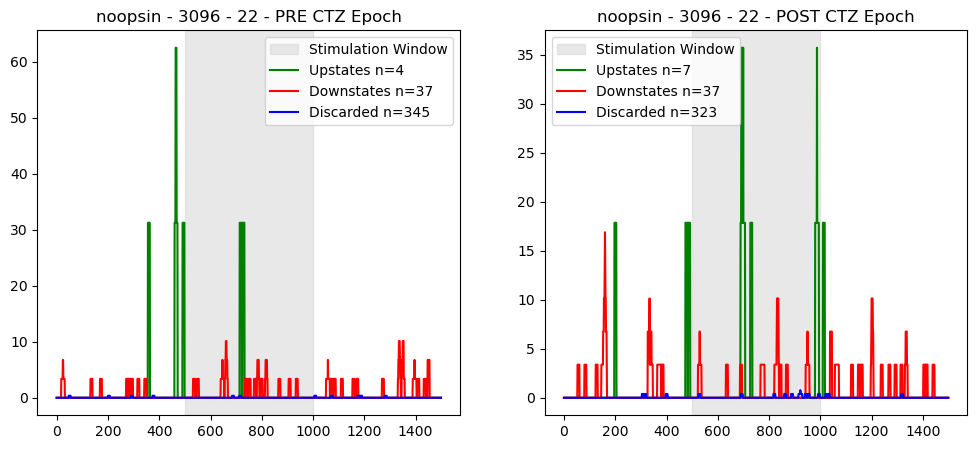

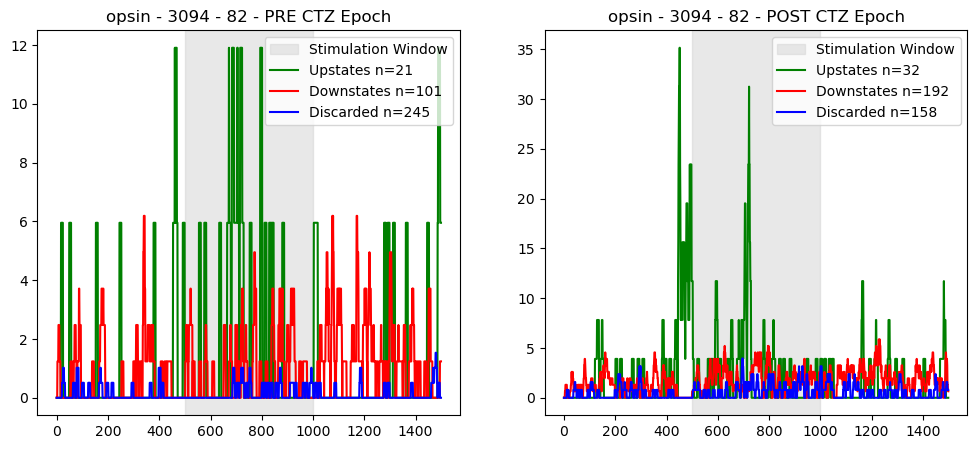

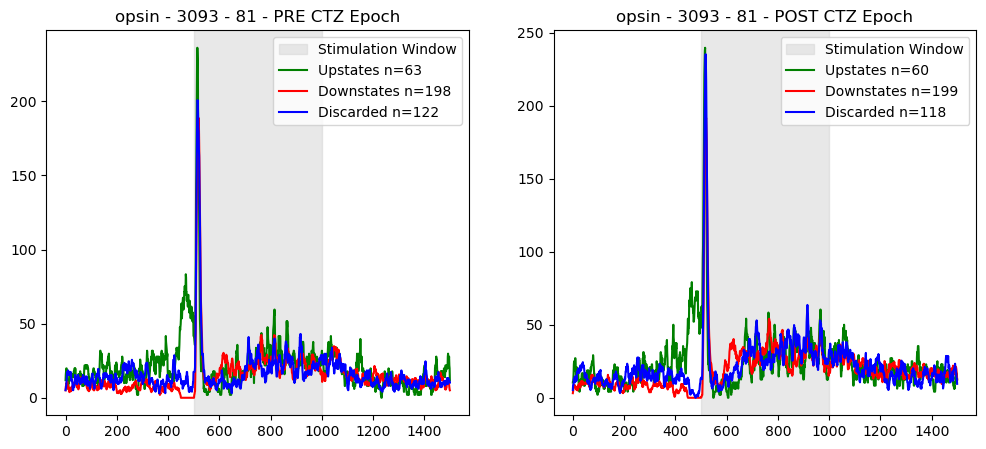

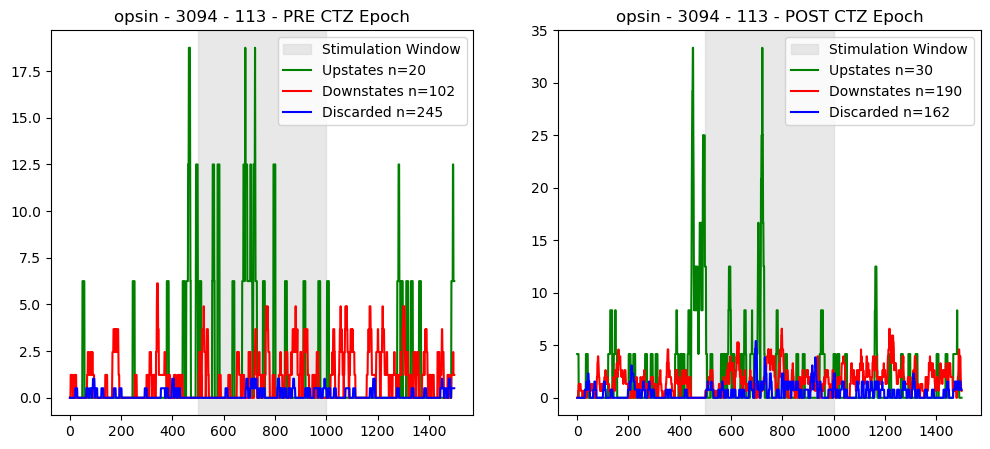

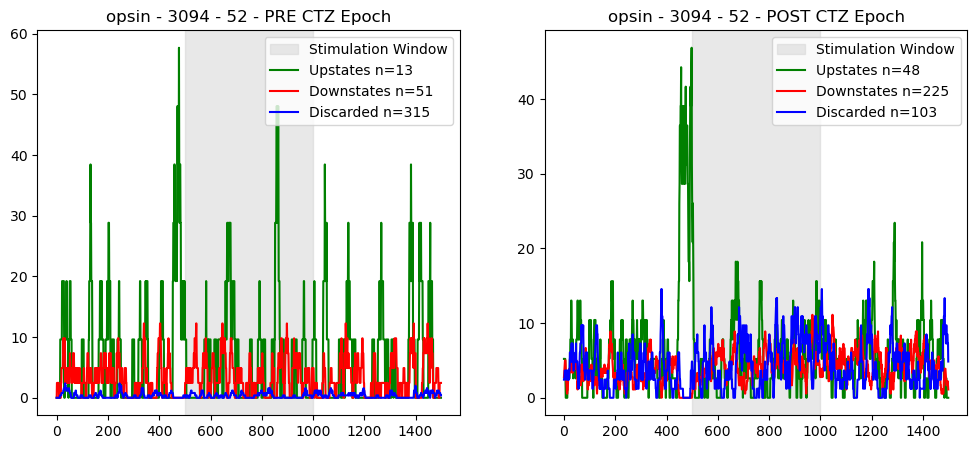

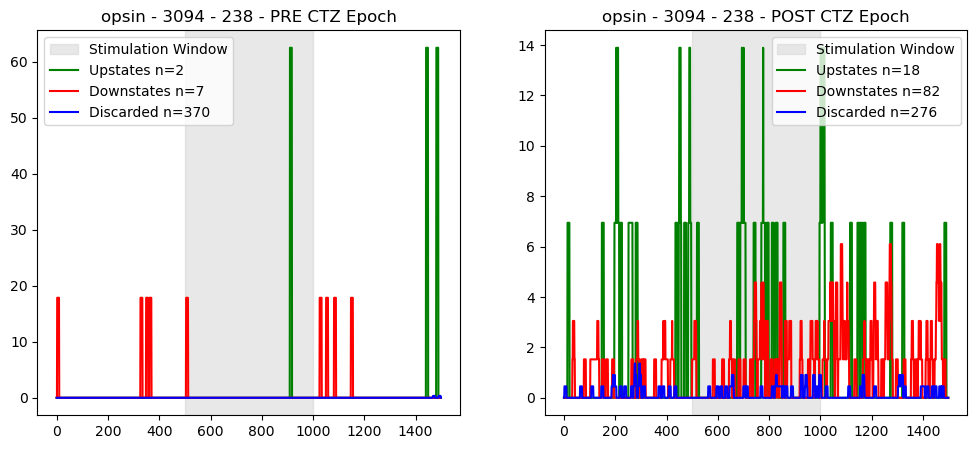

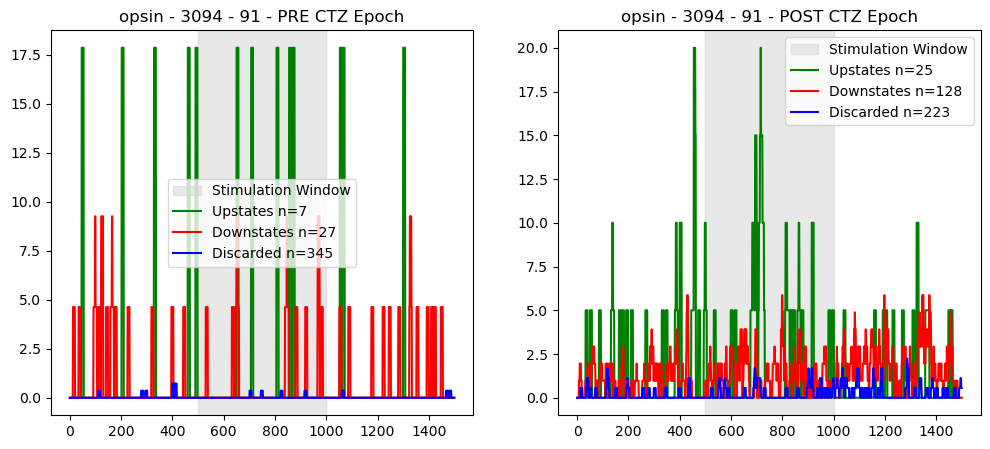

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

file_counter = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: {"pre": 0, "post": 0})))

# Iterate through all .npy files in the specified directory
for file_name in os.listdir(input_directory):
    if file_name.endswith("_combinedmatrix.npy"):
        parts = file_name.split("_")
        group_id, mouse_id, cell_id, ctz_condition = parts[:4]
        # Increment the counter for the corresponding CTZ condition (pre or post)
        file_counter[group_id][mouse_id][cell_id][ctz_condition] += 1
# Print the counts for each unique combination
for group_id, group_data in file_counter.items():
    for mouse_id, mouse_data in group_data.items():
        for cell_id, ctz_data in mouse_data.items():
            print(f"Group: {group_id}, Mouse: {mouse_id}, Cell: {cell_id}")
            print(f"Pre CTZ files: {ctz_data['pre']}, Post CTZ files: {ctz_data['post']}")

from collections import defaultdict
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import convolve


def separate_and_plot_trials(directory, top_percentile=10, bottom_percentile=10, baseline_window=(0, 500), stimulation_window=(500, 1000), max_plots=30, show_discarded=True, smoothing_window=5):
    states_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: {"Upstates": [], "Downstates": [], "Discarded": []}))))
    baseline_start, baseline_end = baseline_window
    stim_start, stim_end = stimulation_window
    plot_count = 0

    cell_data = defaultdict(lambda: {'pre': None, 'post': None}) # Dictionary to store the file paths for each cell in each CTZ condition (pre or post)

    smoothing_kernel = np.ones(smoothing_window) / smoothing_window # Define the smoothing kernel
    
    for file_name in os.listdir(directory): # Iterate through all .npy files in the specified directory
        if file_name.endswith("_combinedmatrix.npy"):
            parts = file_name.split("_")
            group_id, mouse_id, cell_id, ctz_condition = parts[:4]
            file_path = os.path.join(directory, file_name)
            matrix_key = (group_id, mouse_id, cell_id)
            cell_data[matrix_key][ctz_condition] = file_path

    for (group_id, mouse_id, cell_id), files in cell_data.items():
        pre_file_path = files['pre']
        post_file_path = files['post']

        if pre_file_path is None or post_file_path is None:
            continue

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        for idx, (ctz_condition, file_path) in enumerate(zip(["pre", "post"], [pre_file_path, post_file_path])):
            matrix = np.load(file_path)

            # Apply smoothing using convolution
            matrix_smoothed = convolve(matrix, smoothing_kernel[None, :], mode='same')

            baseline_spike_counts = matrix_smoothed[:, baseline_start:baseline_end].sum(axis=1)
            nonzero_spike_counts = baseline_spike_counts[baseline_spike_counts > 0]
            zero_spike_count_indices = np.where(baseline_spike_counts == 0)[0]

            top_threshold = np.percentile(nonzero_spike_counts, 100 - top_percentile) if nonzero_spike_counts.size > 0 else 0
            bottom_threshold = np.percentile(nonzero_spike_counts, bottom_percentile) if nonzero_spike_counts.size > 0 else 0

            for i, spike_count in enumerate(baseline_spike_counts):
                trial = matrix[i]
                if i in zero_spike_count_indices:
                    state = "Discarded"
                elif spike_count >= top_threshold:
                    state = "Upstates"
                elif spike_count <= bottom_threshold:
                    state = "Downstates"
                else:
                    state = "Discarded"
                states_dict[group_id][mouse_id][cell_id][ctz_condition][state].append(trial)

            ax = axes[idx]
            ax.axvspan(stim_start, stim_end, color='lightgray', alpha=0.5, label="Stimulation Window")
            
            for state, color in zip(["Upstates", "Downstates", "Discarded"], ['green', 'red', 'blue']):
                if state == "Discarded" and not show_discarded: # Skip plotting discarded trials if show_discarded is False
                    continue 
                trials = states_dict[group_id][mouse_id][cell_id][ctz_condition][state] # Get the trials for the current state
                if trials: # If there are any trials in the current state
                    #convert ms to Hz by multiplying by 1000
                    mean_trials_smoothed = convolve(np.mean(trials, axis=0), smoothing_kernel, mode='same')*1000  # Apply smoothing to mean trials, convert to Hz 

                    ax.plot(mean_trials_smoothed, color=color, label=f"{state} n={len(trials)}") # Plot the mean trials for the current state in the corresponding color

            ax.legend()
            ax.set_title(f"{group_id} - {mouse_id} - {cell_id} - {ctz_condition.upper()} CTZ Epoch")

        plt.show()
        plot_count += 1
        if plot_count >= max_plots:
            break

    return states_dict



top_percentile = 25
bottom_percentile = 25
baseline_window = (350NEur, 500)  # User-defined baseline window for spike sum calculation
stimulation_window = (500, 1000)  # Stimulation window for labeling the plot

states_dict = separate_and_plot_trials(input_directory, top_percentile, bottom_percentile, baseline_window, stimulation_window, show_discarded=True, smoothing_window=8)
